In [726]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import innvestigate

from keras.models import load_model
from keras import backend as K
from keras.utils import Sequence

from utils import load_nifti, normalize_float, IntensityRescale, replace_classifier
from config import *

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "5"
set_session(tf.Session(config=config))

In [3]:
zero_one_normalize = True
dtype = np.float32
z_factor = 0.525
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/"

In [4]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

train_lesions_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_lesions.h5', 'r')
holdout_lesions_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_lesions.h5', 'r')

lesion_masks_train = train_lesions_h5['masks']
lesion_masks_holdout = holdout_lesions_h5['masks']

In [5]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [6]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

## Make dataset

In [7]:
intensity = IntensityRescale(masked=False)

In [8]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


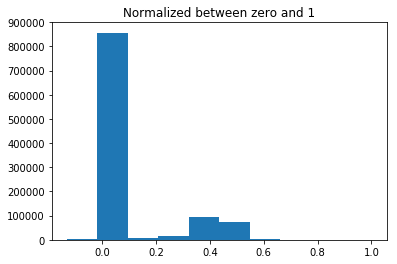

In [9]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


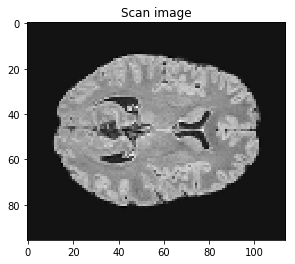

In [10]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

In [11]:
lesion_masks_train.shape

(124, 96, 114, 96)

# Model

In [19]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [868]:
# load model weights
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_6.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [21]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [22]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [23]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0010960017098113894


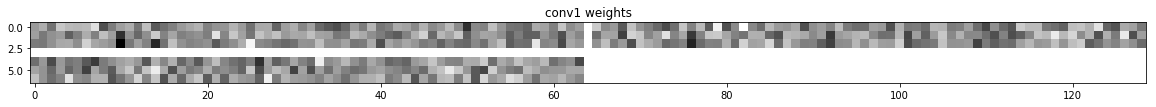

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0014732700074091554


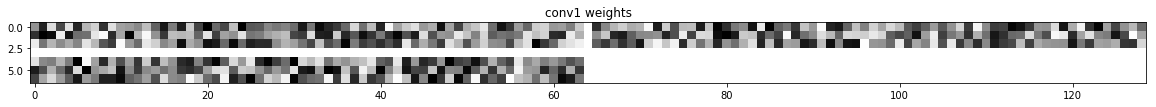

In [24]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

# Visualization

In [49]:
def plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis):
    r = 2
    c = 2
    # Displaying the gradient
    plt.figure(figsize=(14,12))
    plt.subplots_adjust(hspace=0.15, wspace=0.)
    ax1 = plt.subplot(r, c, 1)
    plt.imshow(X_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Scan")
    ax2 = plt.subplot(r, c, 2)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Lesion mask")
    ax3 = plt.subplot(r, c, 3)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='Reds', alpha=0.6, vmin=0.1)
    plt.title("Lesion mask over scan")
    ax4 = plt.subplot(r, c, 4)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(analysis.squeeze()[:,:,sl], cmap='Reds', interpolation='nearest', alpha=0.6)
    plt.title("Heatmap overlayed")
    plt.show()

In [50]:
num_trials = 10
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [51]:
import keras.layers
import keras.models
import keras.utils

import innvestigate.utils as iutils

In [52]:
model = load_model(model_path)
#model = replace_classifier(model, activation='tanh', units=1)
model = replace_classifier(model, activation=None, units=1) # use logits
model_dir = os.path.join(result_dir, weights[5]) # select best model
#model_dir = os.path.join(result_dir, weights[1]) # select other model
model.load_weights(model_dir)

In [869]:
image_idx = 8
sl = 48
b = 1
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=b, shuffle=False, z_factor=z_factor)
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [870]:
print(label)

[1]


In [871]:
image.shape

(1, 96, 114, 96, 1)

In [872]:
pred = model.predict(image)
print("Model prediction: {} with final output: {:.4f}".format((pred.item()>=0.5)*1, pred.item()))

Model prediction: 0 with final output: 0.1290


In [873]:
lesion_masks_holdout.shape

(23, 96, 114, 96)

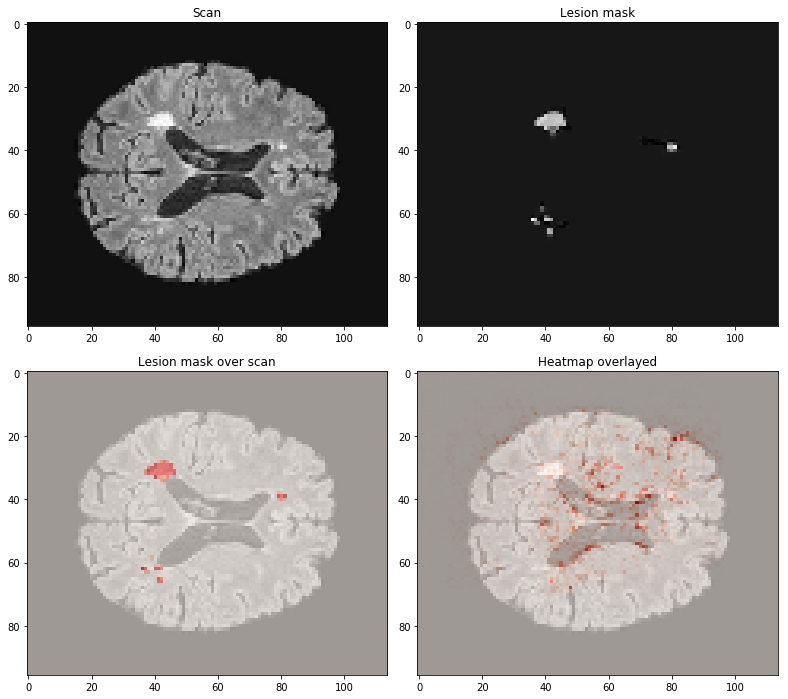

In [874]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [73]:
def heatmap_lesion_similarity(heatmap, lesions, intensity=True):
    assert(heatmap.shape == lesions.shape)
    hm = np.copy(heatmap)
    hm = heatmap/np.max(heatmap)
    if not intensity:
        #thresh = np.max(heatmap)/20
        # threshold hard to fix.. better use with intensities
        thresh = np.max(heatmap)/(6)
        #thresh = 1e-4
        hm[np.where(heatmap>thresh)] = 1.
        hm[np.where(heatmap<=thresh)] = 0.
    plt.imshow(hm[:,:,sl], cmap='gray')
    plt.show()
    l = lesions * hm
    similarity = np.sum(l)
    if not intensity:
        similarity /= np.sum(lesions)
    return similarity

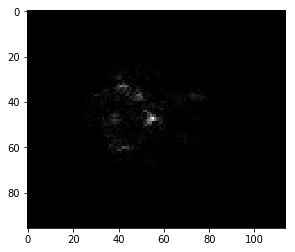

49.832426010140665


In [74]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

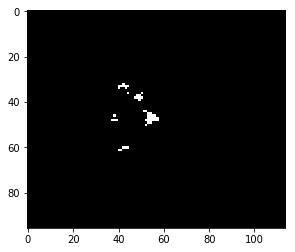

0.11006692571447338


In [75]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

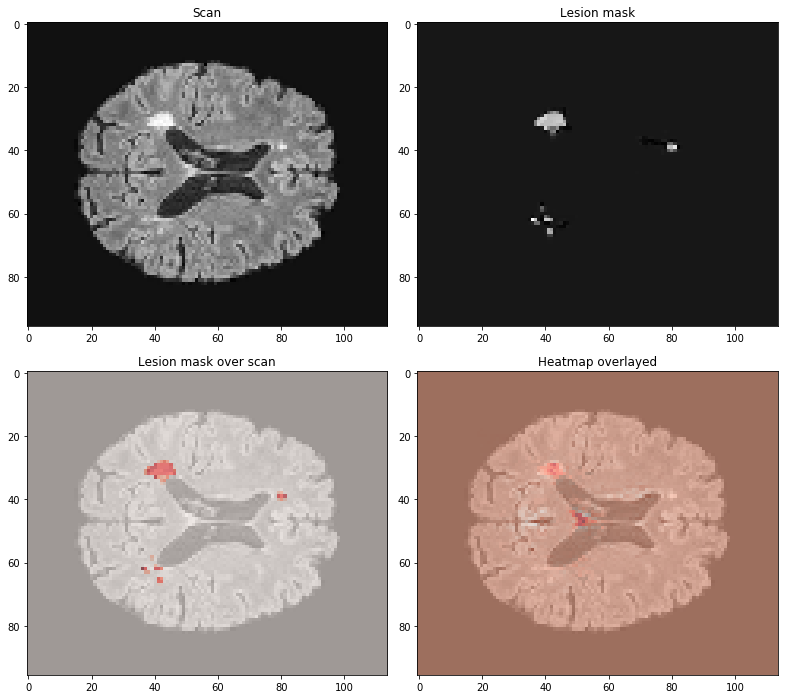

In [38]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

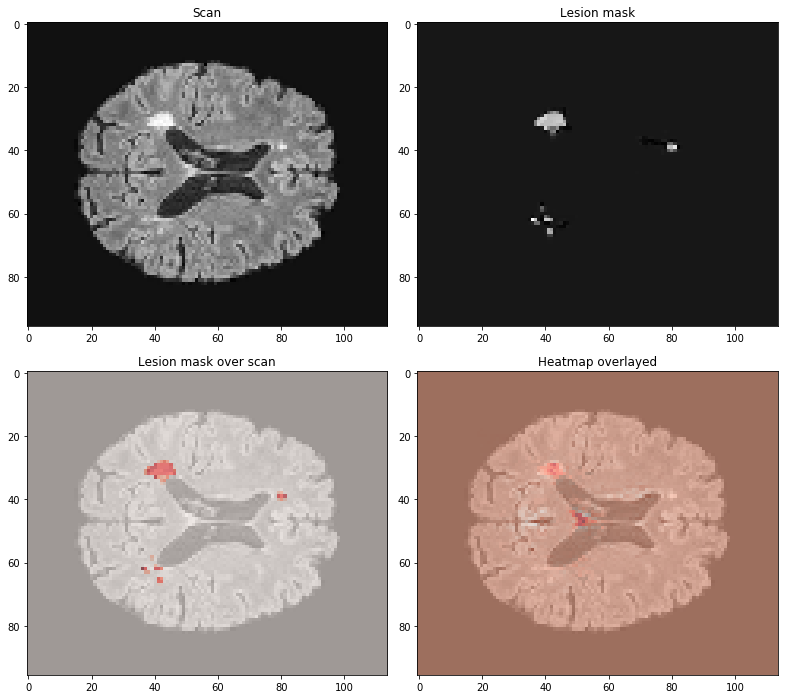

In [39]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

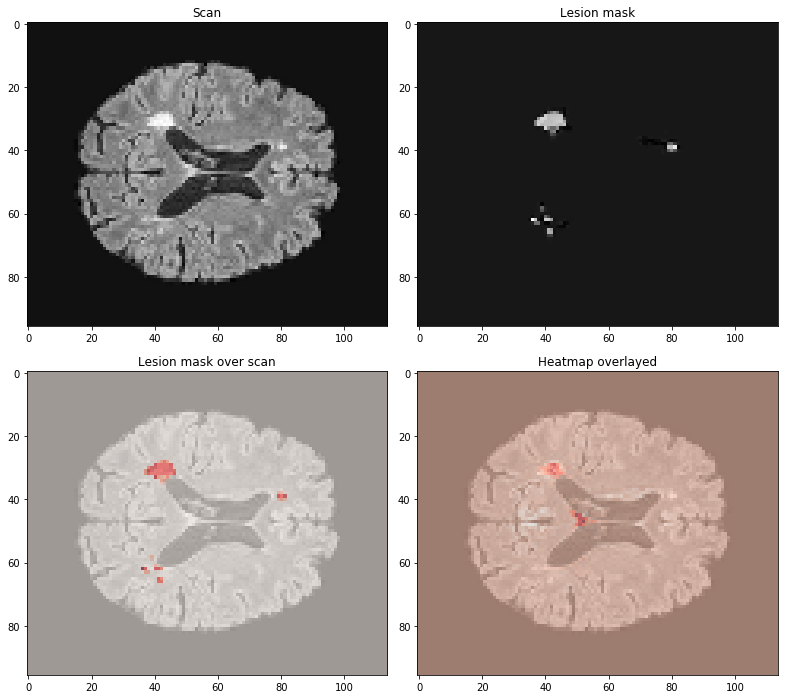

In [40]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

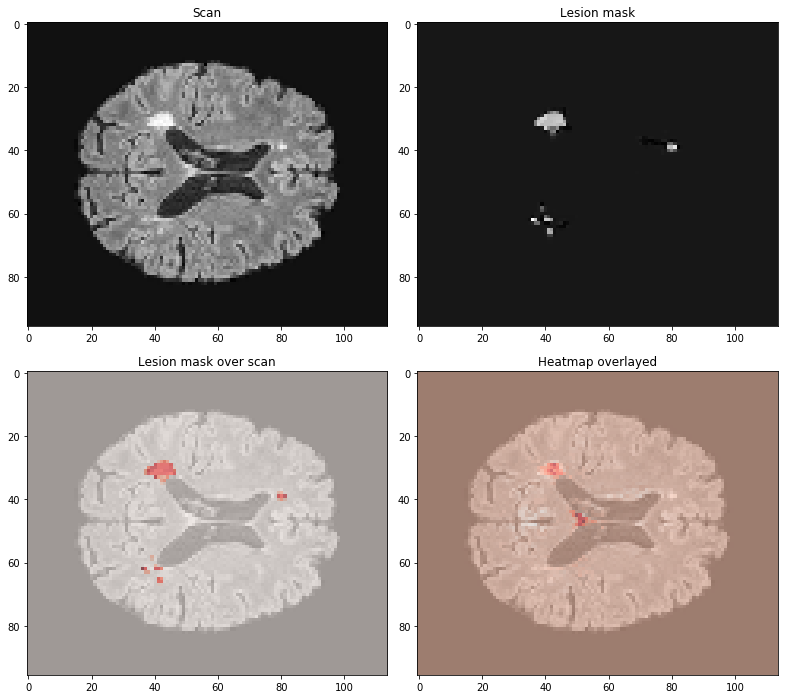

In [44]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

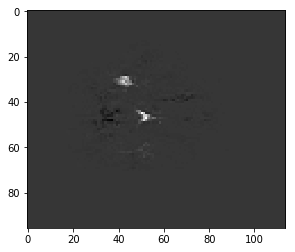

47.5353595415347


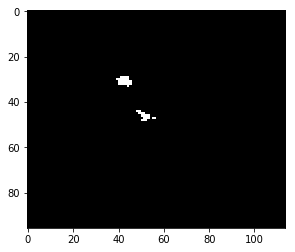

0.15025701928315055


In [45]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

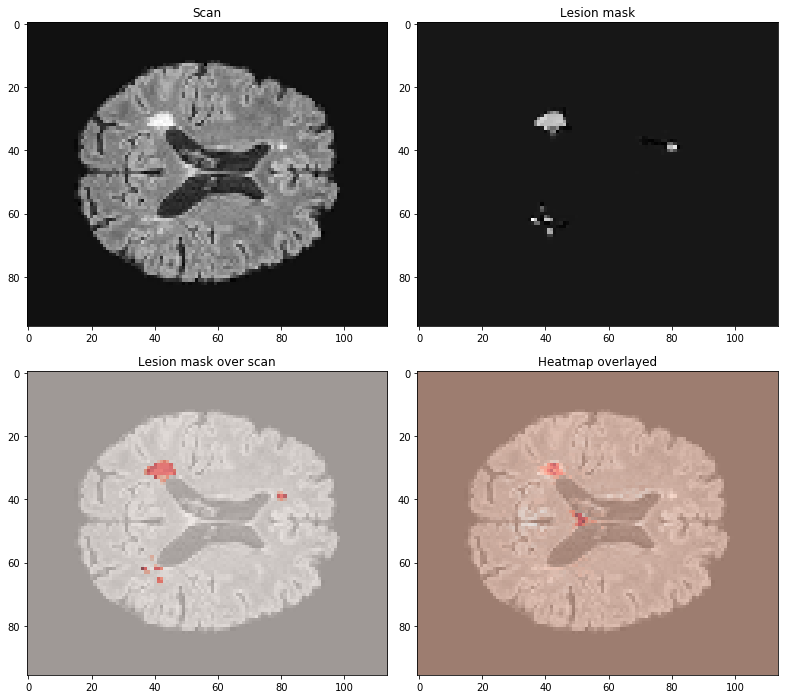

In [58]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=0.001)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

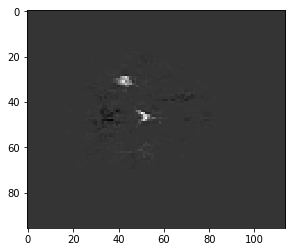

47.39755262847862


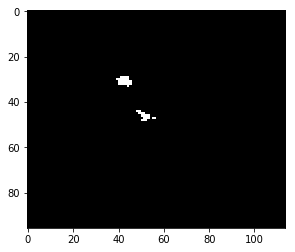

0.14778301604657984


In [59]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

## Using only the pre-trained model / no fine-tuning

In [43]:
# loading pre-trained model
model = load_model(model_path)
model = replace_classifier(model, activation='tanh', units=1)

In [44]:
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [45]:
print(label)

[1]


In [46]:
pred = model.predict(image)
print("Model prediction: {} with final simgoid output: {:.4f}".format((pred.item()>=0.5)*1, pred.item()))

Model prediction: 0 with final simgoid output: 0.1290


In [47]:
image.shape

(1, 96, 114, 96, 1)

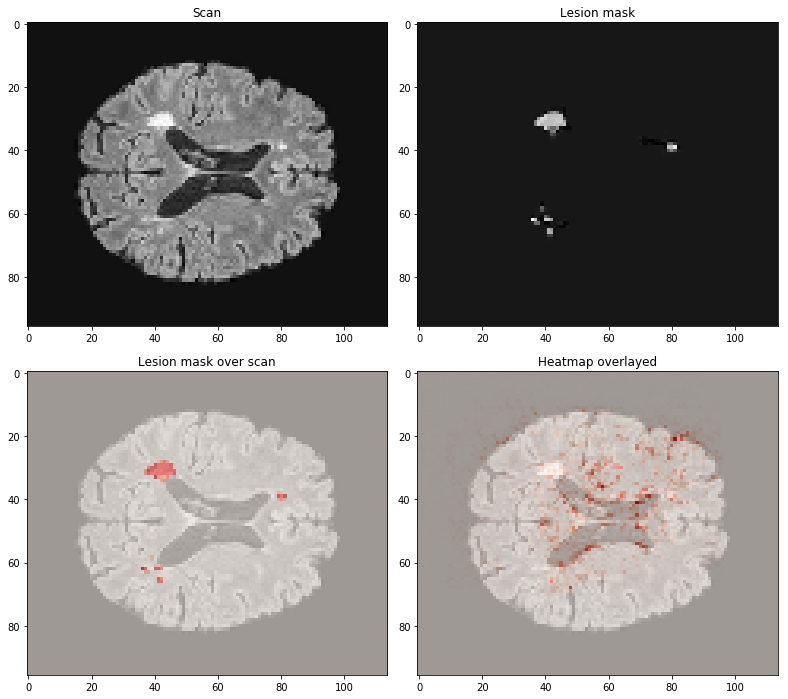

In [48]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [49]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

0.03500898217269412


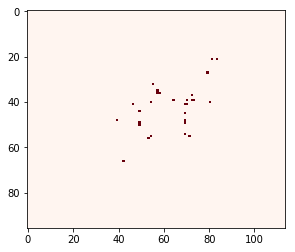

0.02656913015576147


In [50]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

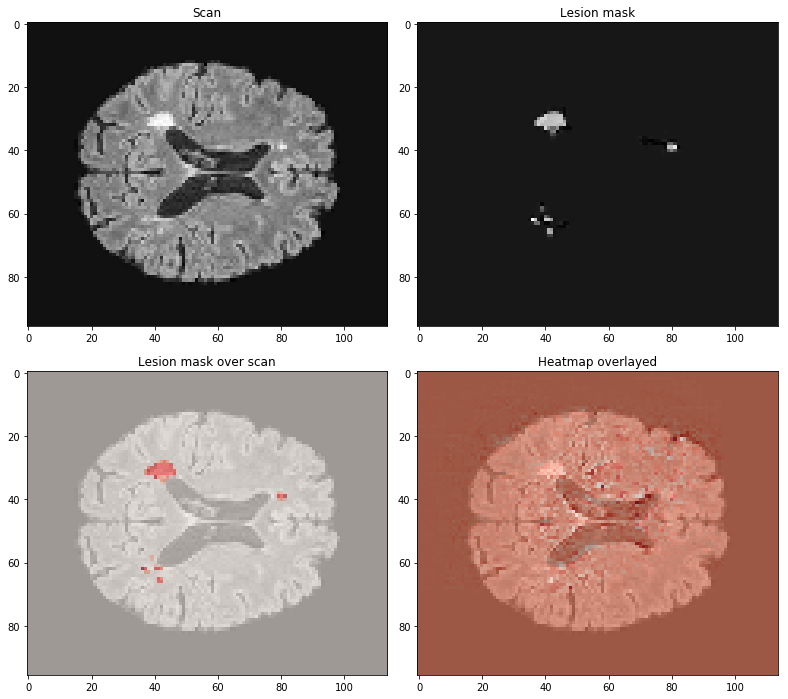

In [51]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

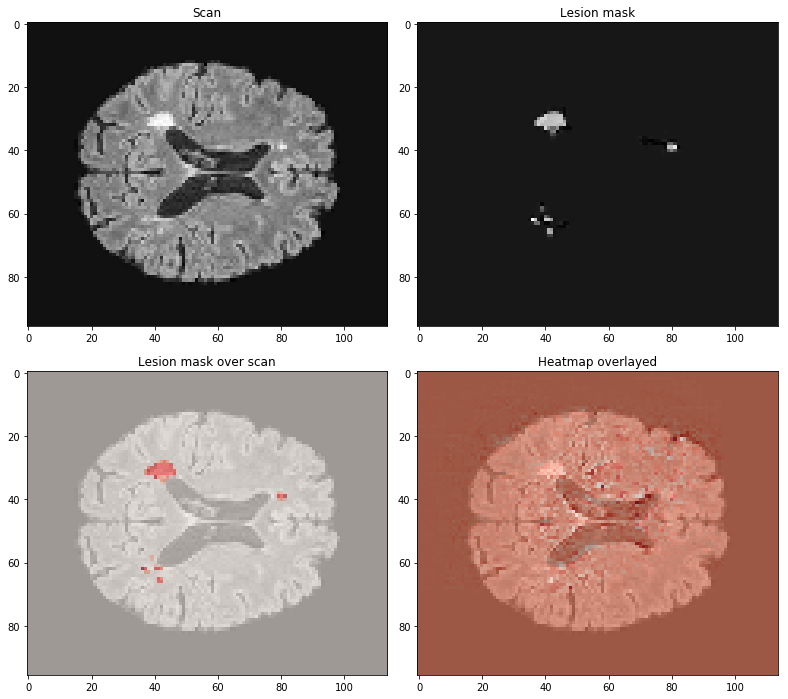

In [52]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

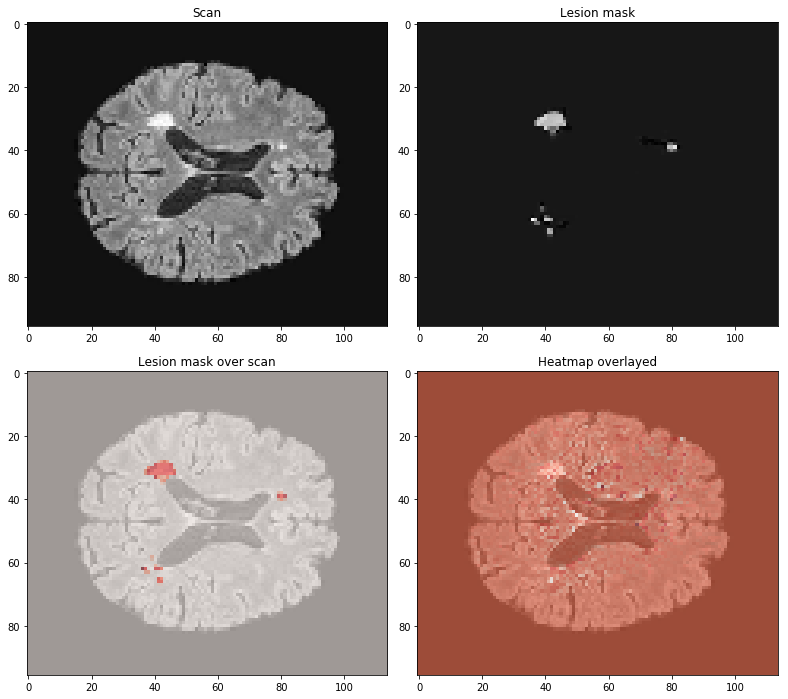

In [53]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

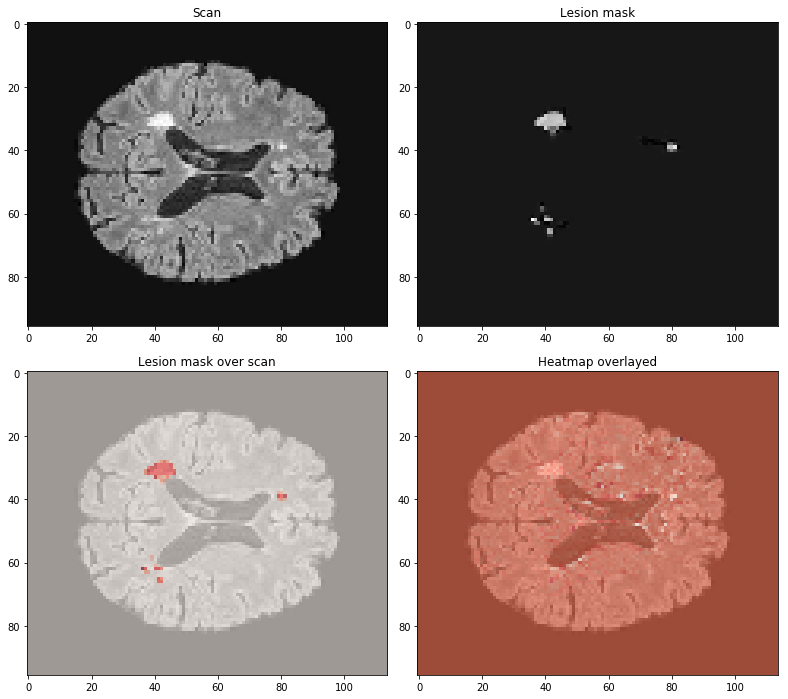

In [54]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

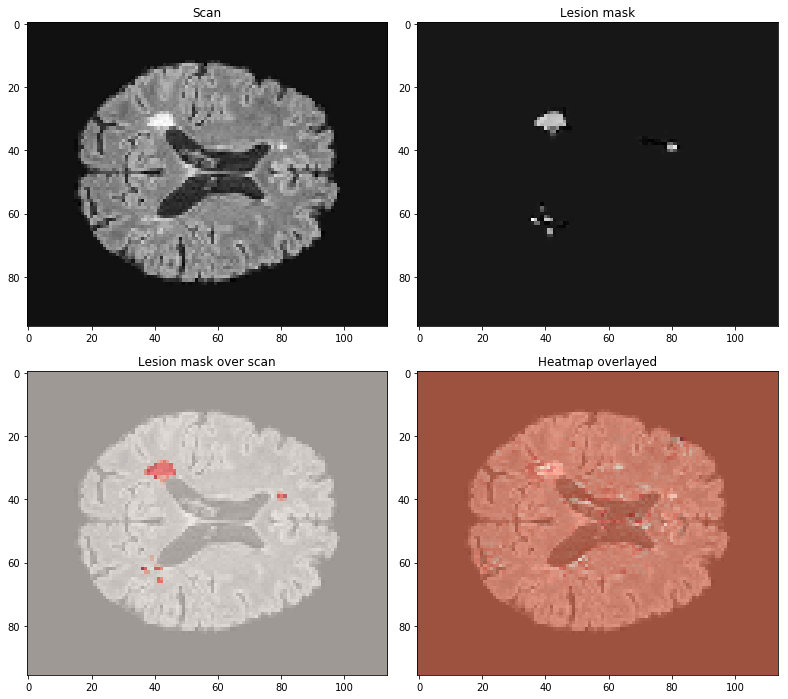

In [55]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

## Random weights

In [56]:
# use random weights
model = load_model(model_path)
reset_weights(model)

In [57]:
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [58]:
print(label)

[1]


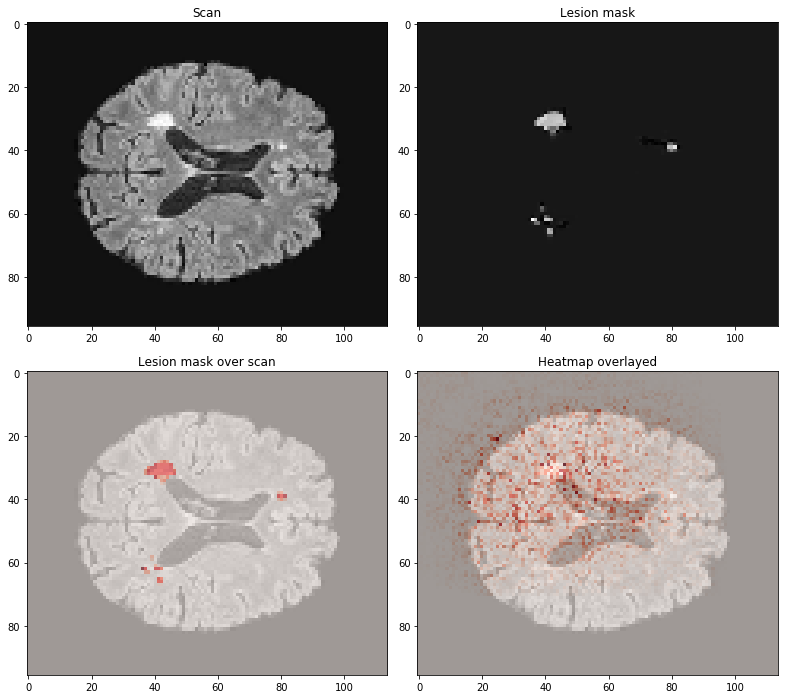

In [59]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [60]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

0.10814946932365635


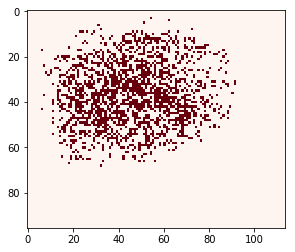

0.4016125341692888


In [61]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

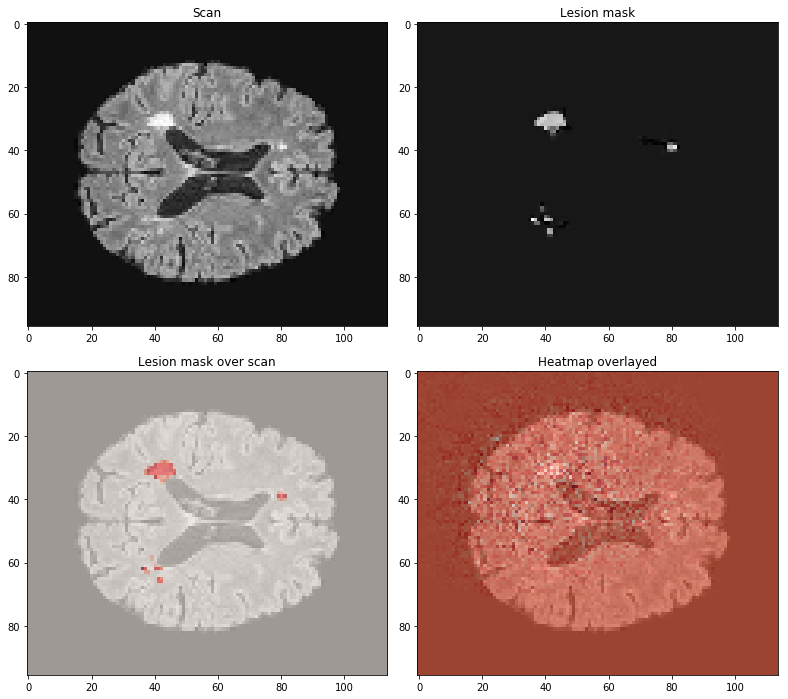

In [62]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

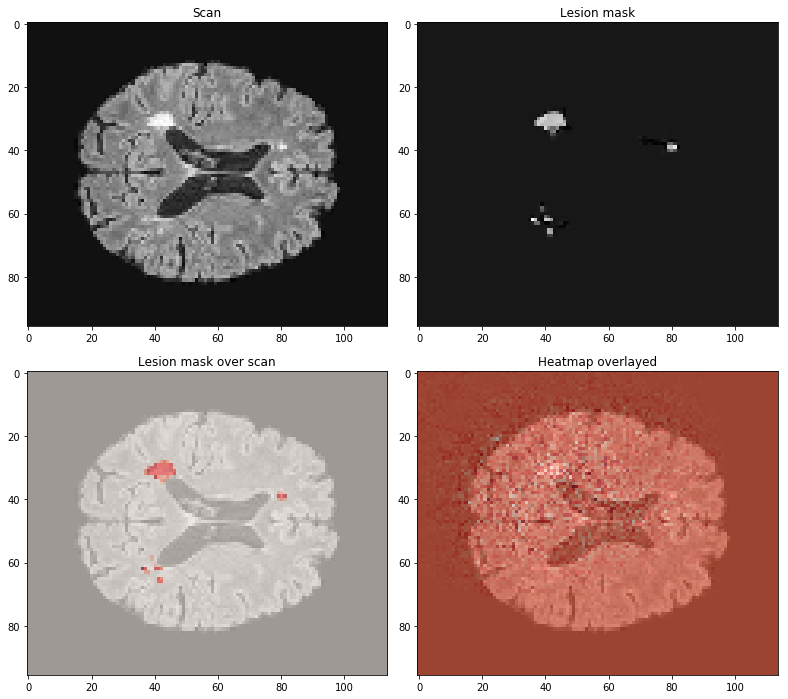

In [63]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

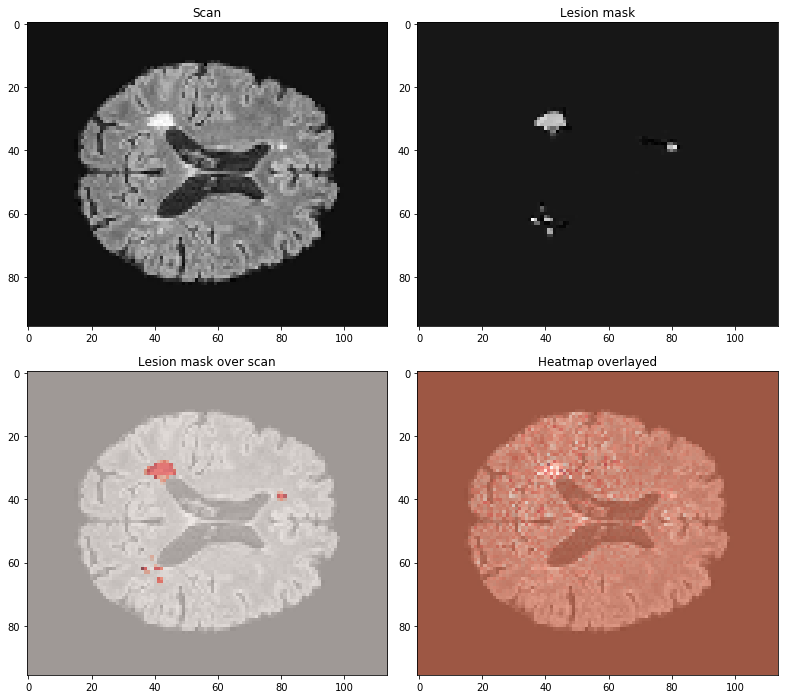

In [64]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

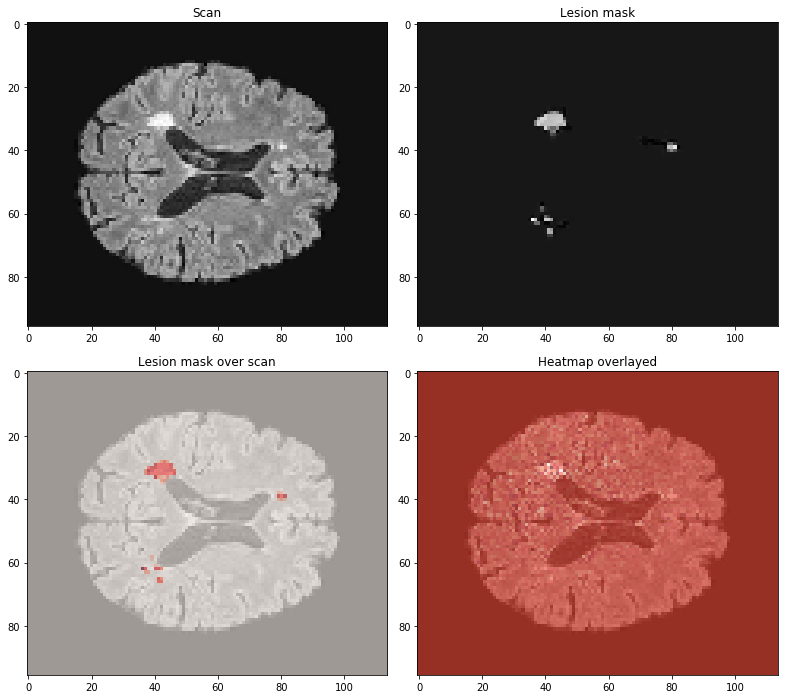

In [65]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

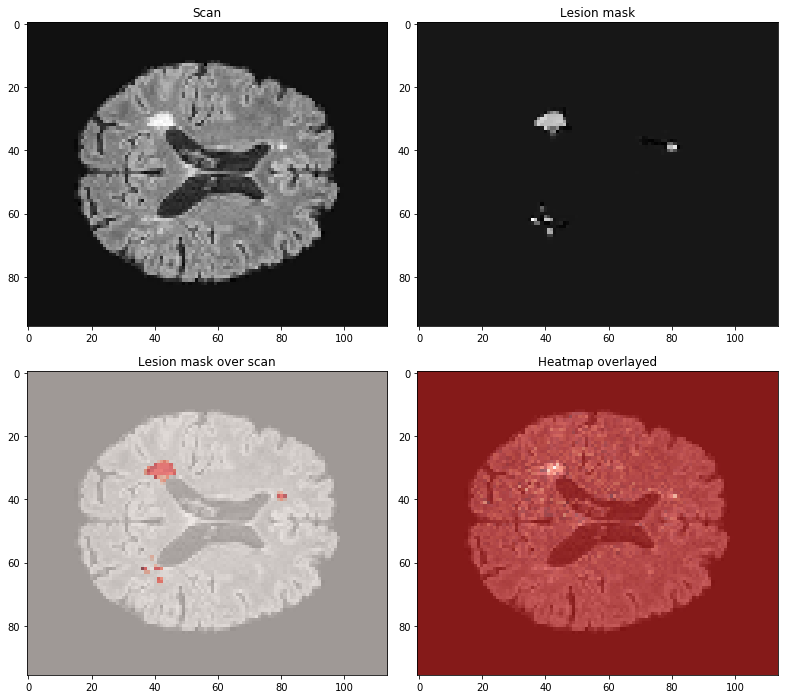

In [66]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

# Average heatmaps

In [1306]:
image_file_dir = "/analysis/fabiane/documents/publications/MS_CNN_VIS"

In [883]:
# load model
model = load_model(model_path)
beheaded_model = replace_classifier(model, activation=None, units=1) # use logits
model_dir = os.path.join(result_dir, weights[5]) # select best model
beheaded_model.load_weights(model_dir)
model.load_weights(model_dir)

In [884]:
mask = np.expand_dims(load_nifti("/analysis/share/Ritter/MS/Test/alt/zoomed_mask2.nii.gz", z_factor=z_factor), 3)

/home/fabiane/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [885]:
mask[mask <1e-5] = 0.0

In [886]:
test_loader = CISDataset(X_holdout,
                         y_holdout,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None)

In [887]:
train_loader = CISDataset(X_train,
                         y_train,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None)

In [898]:
def plot_heatmap(heatmap, scan_avg, vmin, vmax, title="Heatmap sum", cmap='seismic', sl=(48, 60, 48), show_average=True):
    vmin = -0.05
    vmax = 0.05
    #vmax = vmin * -1
    #vmin = np.min(heatmap)
    #vmax = np.max(heatmap)
    plt.figure(figsize=(16, 12))
    plt.subplot(2, 3, 1)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[:,:,sl[0]], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.subplot(2, 3, 2)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.subplot(2, 3, 3)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[sl[2],:,:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.colorbar()
    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    plt.show()

In [1518]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap2(heatmap, scan_avg, vmin, vmax, title=None, cmap='seismic', sl=((48, 60, 48),), show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of entire individual by iterating over
    slice combinations.
    """
    vmin = -0.05
    vmax = 0.05
    sl_list = list(sl)
    nrows = len(sl_list)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.49, 4.5 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]

    for count, sl in enumerate(sl_list):    
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray')
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)

        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)

        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray')
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.05, 0.01, p2[2], 0.01]) # settings for whole subject
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)   
        
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True)
    plt.show()

In [1505]:
def plot_heatmap_zero_one(heatmaps, scan_avg, vmin, vmax, title=None, cmap='seismic', show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of averages for class zero and class one.
    Iterate over heatmaps rather than slices.
    """
    vmin = -0.05
    vmax = 0.05
    sl = (48, 60, 48)
    nrows = len(heatmaps)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13., 5 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0.15})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]
    
    for count, heatmap in enumerate(heatmaps):    
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray')
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
            
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
        if title is not None:
            axes[count][1].set_title(title[count], fontsize=16, y=1.03)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray')
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.08, 0.07, p2[2], 0.03]) # settings for average
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)
    
    
    # ensure colorbar is within plot
    #fig.subplots_adjust(bottom=0.2)
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True)
    plt.show()

In [1285]:
def get_heatmap_sum(dataloader, shape, beheaded_model, prediction_model, mode='prediction'):
    """
    Return the total heatmap sum of all subjects wiithin the dataset.
    In the code "one_" stands for prediction class and "zero_" for null class.
    
    Arguments
        mode: Can be one of 'prediction' or 'label'. Former separates
            true positives and true negatives (ignores false
            predictions), latter separates only by label.
        
    """
    
    one_heatmaps = np.zeros(shape=shape)
    zero_heatmaps = np.zeros(shape=shape)
    one_count = 0
    zero_count = 0
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)

    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        pred = (prediction_model.predict(image) > 0.5) * 1.

        # Applying the analyzer
        analysis = gradient_analyzer.analyze(image)

        if mode == 'prediction':
            # Sorting by correct predictions
            if label == 1 and pred == 1:
                one_heatmaps += analysis
                one_count += 1
            elif label == 0 and pred == 0:
                zero_heatmaps += analysis
                zero_count += 1
        elif mode == 'label':
            # Sorting by label
            if label == 1:
                one_heatmaps += analysis
                one_count += 1
            elif label == 0:
                zero_heatmaps += analysis
                zero_count += 1
        
    print("Sorted by {}".format(mode))
    print("total {}".format(len(dataloader)))
    print("one {}".format(one_count))
    print("zero {}".format(zero_count))
    # Average values over number of samples
    one_heatmaps /= one_count
    zero_heatmaps /= zero_count
    
    return one_heatmaps, zero_heatmaps

In [1286]:
ms_heatmaps_holdout, hc_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=beheaded_model, prediction_model=model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Sorted by label
total 23
one 13
zero 10


In [1287]:
ms_heatmaps_train, hc_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=beheaded_model, prediction_model=model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Sorted by label
total 124
one 63
zero 61


In [1288]:
TP_heatmaps_holdout, TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=beheaded_model, prediction_model=model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Sorted by prediction
total 23
one 12
zero 9


In [1289]:
TP_heatmaps_train, TN_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=beheaded_model, prediction_model=model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


Sorted by prediction
total 124
one 54
zero 60


In [1290]:
# Create average image for background
avg_train_image = np.mean(X_train, axis=0)
plt.imshow(np.rot90(np.squeeze(avg_train_image)[:,:,sl], axes=(0,1)), cmap='gray')
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Holdout averages

### MS vs HC

In [1496]:
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [1499]:
plt.rc('font', family='serif')

In [1502]:
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['serif']))
print(font)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf


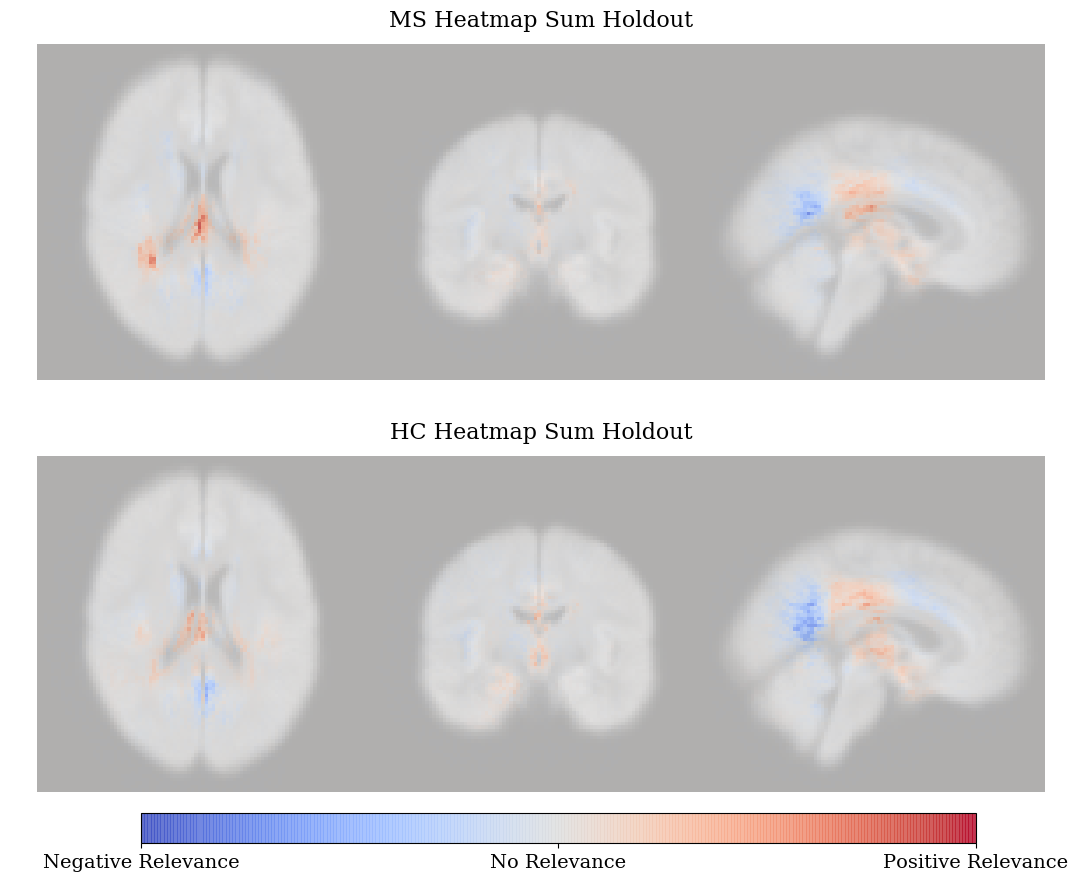

In [1506]:
hms = [ms_heatmaps_holdout, hc_heatmaps_holdout]
titles = ["MS Heatmap Sum Holdout", "HC Heatmap Sum Holdout"]
show_cb = True
fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
#fp = None
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='coolwarm', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

### TP vs TN

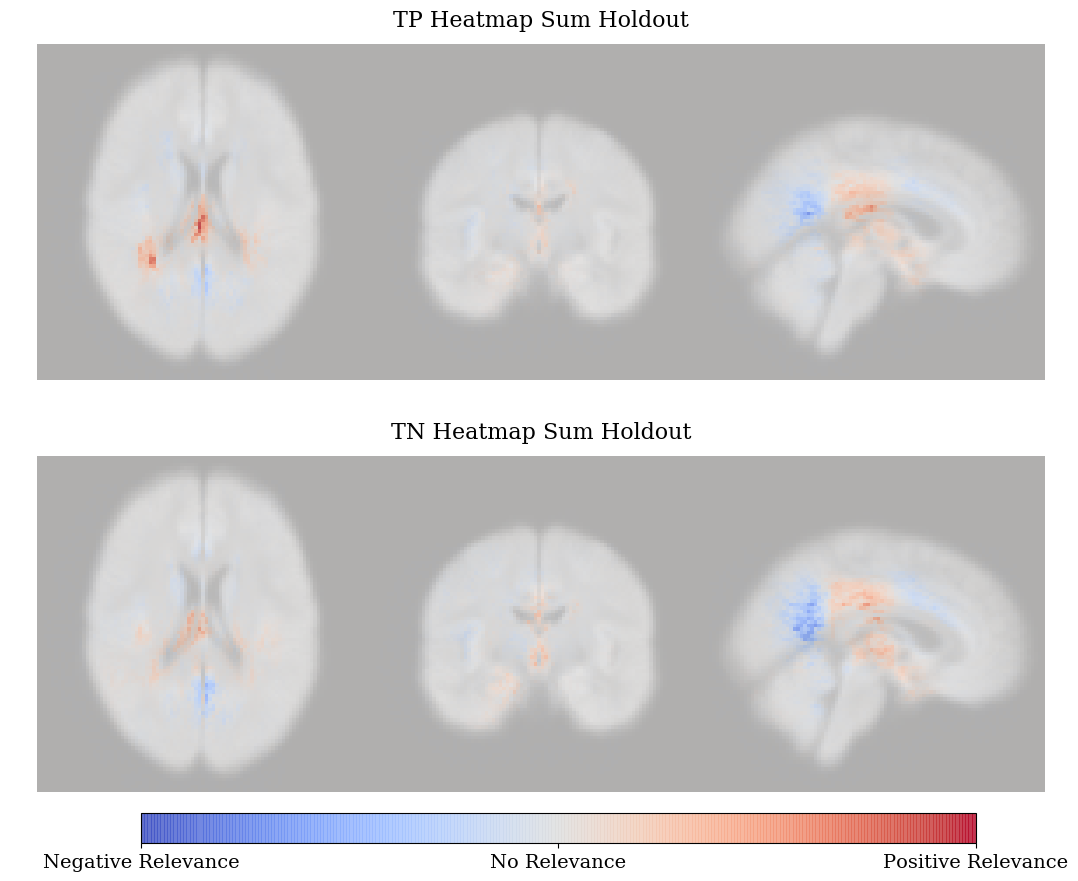

In [1507]:
hms = [TP_heatmaps_holdout, TN_heatmaps_holdout]
titles = ["TP Heatmap Sum Holdout", "TN Heatmap Sum Holdout"]
show_cb = True
fp = os.path.join(image_file_dir, "average_holdout_TP_TN_coolwarm_serif.png")
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='coolwarm', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

# Training averages

### MS vs HC

2.4778343122768636


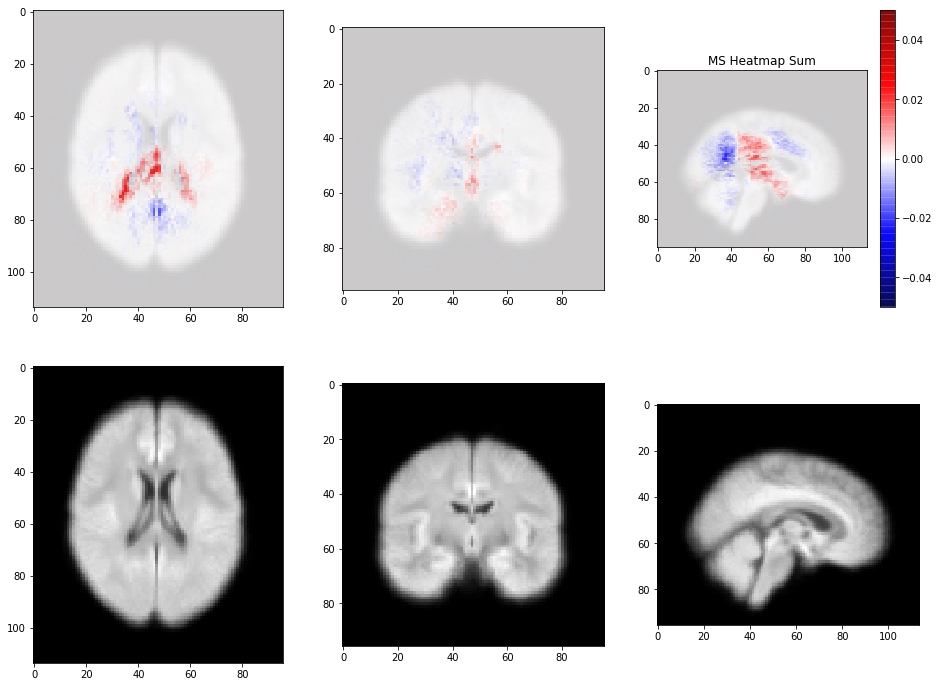

-1.7296983448481573


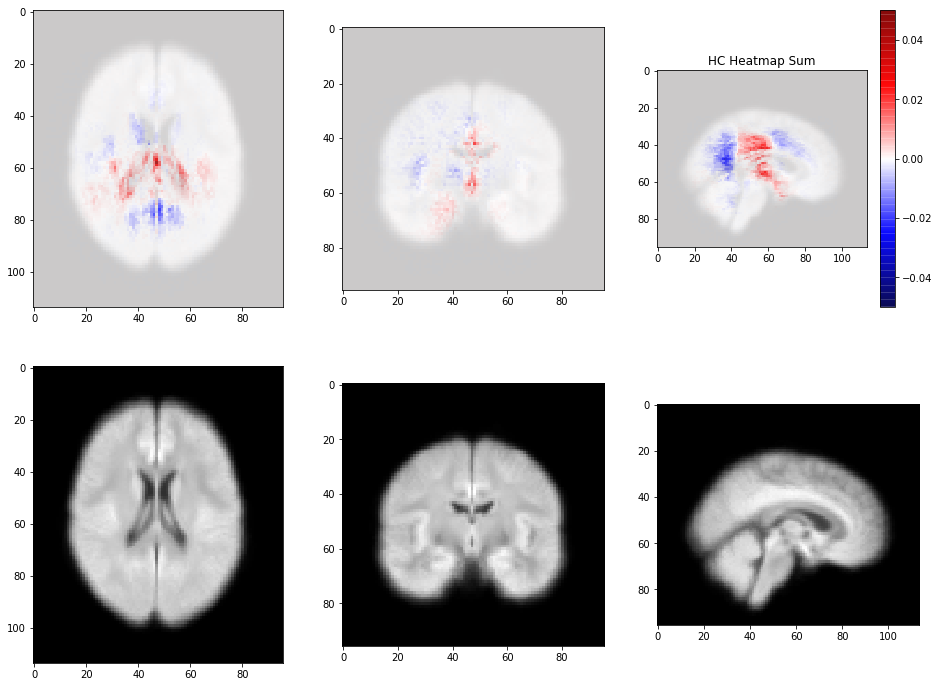

In [852]:
hms = [ms_heatmaps_train, hc_heatmaps_train]
titles = ["MS Heatmap Sum", "HC Heatmap Sum"]
for hm, title in zip(hms, titles):
    print(np.sum(hm))
    plot_heatmap(hm, avg_train_image, vmin, vmax, title, cmap='seismic')

### TP vs TN

2.8695573855168734


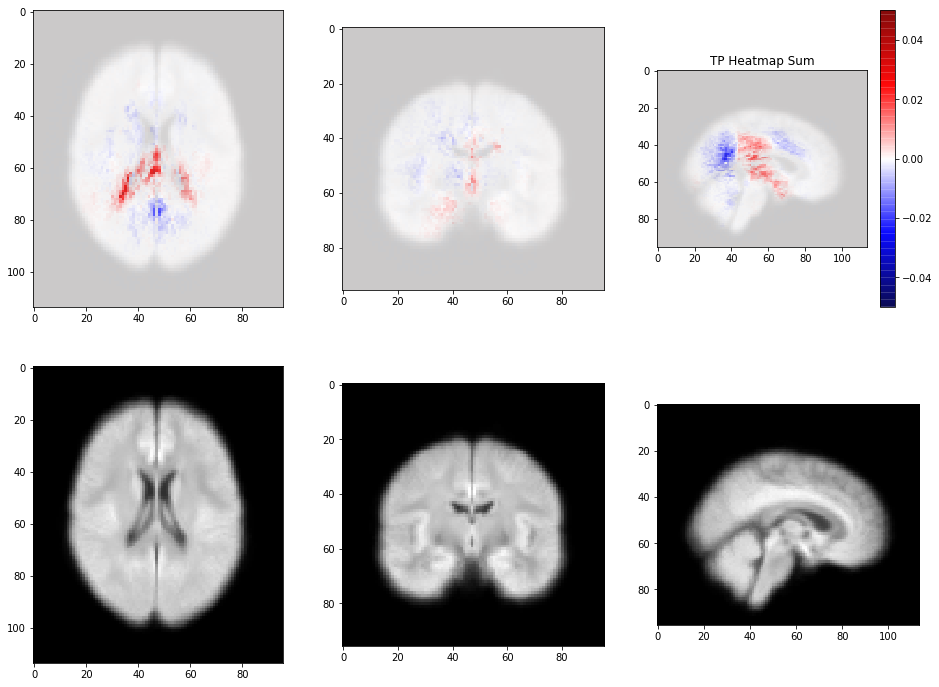

-1.7296984606285826


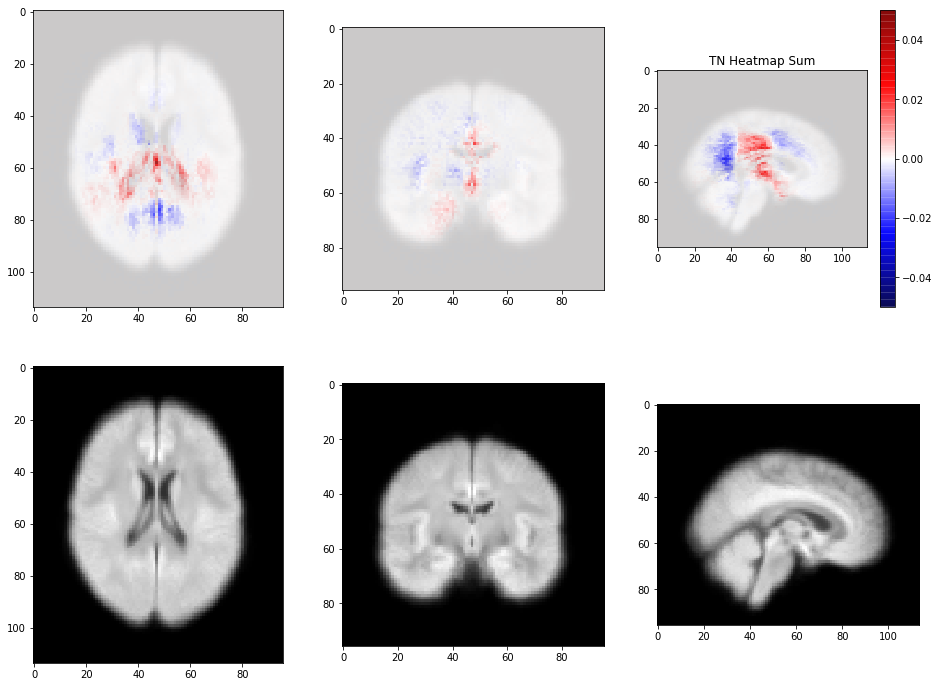

In [853]:
hms = [TP_heatmaps_train, TN_heatmaps_train]
titles = ["TP Heatmap Sum", "TN Heatmap Sum"]
for hm, title in zip(hms, titles):
    print(np.sum(hm))
    plot_heatmap(hm, avg_train_image, vmin, vmax, title, cmap='seismic')

In [710]:
print(np.sum(ms_heatmaps_train))
print(np.sum(hc_heatmaps_train))

2.4363267745976214
-1.8552411610413297


In [689]:
print(np.sum(ms_heatmaps_train))
print(np.sum(hc_heatmaps_train))

1.966618770852537
-1.8151282016099968


### Gradient based

In [206]:
ms_heatmaps = np.zeros_like(analysis)
hc_heatmaps = np.zeros_like(analysis)
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    # Normalize heatmaps
    analysis = (analysis - np.min(analysis))/(np.max(analysis) - np.min(analysis))
    # Sorting by label
    if label == 1:
        ms_heatmaps += analysis
    else:
        hc_heatmaps += analysis

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [207]:
# Average values over number of samples
ms_heatmaps /= len(test_loader)
hc_heatmaps /= len(test_loader)

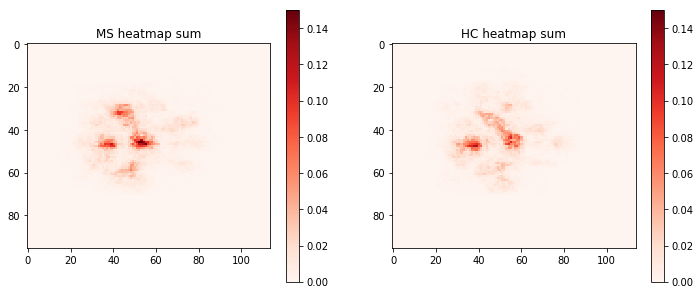

In [208]:
plt.figure(figsize=(12, 5))
vmin = np.min(np.squeeze(ms_heatmaps)[:,:,sl])
vmax = np.max(np.squeeze(ms_heatmaps)[:,:,sl])
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(ms_heatmaps)[:,:,sl], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("MS heatmap sum")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(hc_heatmaps)[:,:,sl], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("HC heatmap sum")
plt.colorbar()
plt.show()

In [817]:
def replace_activations(model, activation=keras.activations.relu):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Conv3D):
            layer.activation = activation
    return model

In [818]:
#model = replace_activations(model)
#opti = keras.optimizers.Adam(lr=0.0005, decay=0.002)
#model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])

#beheaded_model = replace_activations(beheaded_model)
#opti = keras.optimizers.Adam(lr=0.0005, decay=0.002)
#beheaded_model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])

# Visualizing 4 subjects

### MS

In [1445]:
# find subjects with highest sigmoid output
scores = []
for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]
    # Get predictions
    score = model.predict(image)
    scores.append(score[0][0])
idx_list = np.argsort(-np.array(scores))[:4]

print("#########")
for idx in idx_list:
    print("Index %i" %idx)
    print("Score %f" % scores[idx])
    print("#########")

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


#########
Index 6
Score 0.996423
#########
Index 4
Score 0.980106
#########
Index 8
Score 0.973384
#########
Index 12
Score 0.970622
#########


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


pred [1.] 
sigmoid score [0.99642295]
beheaded score 5.629638
analysis sum 6.679100


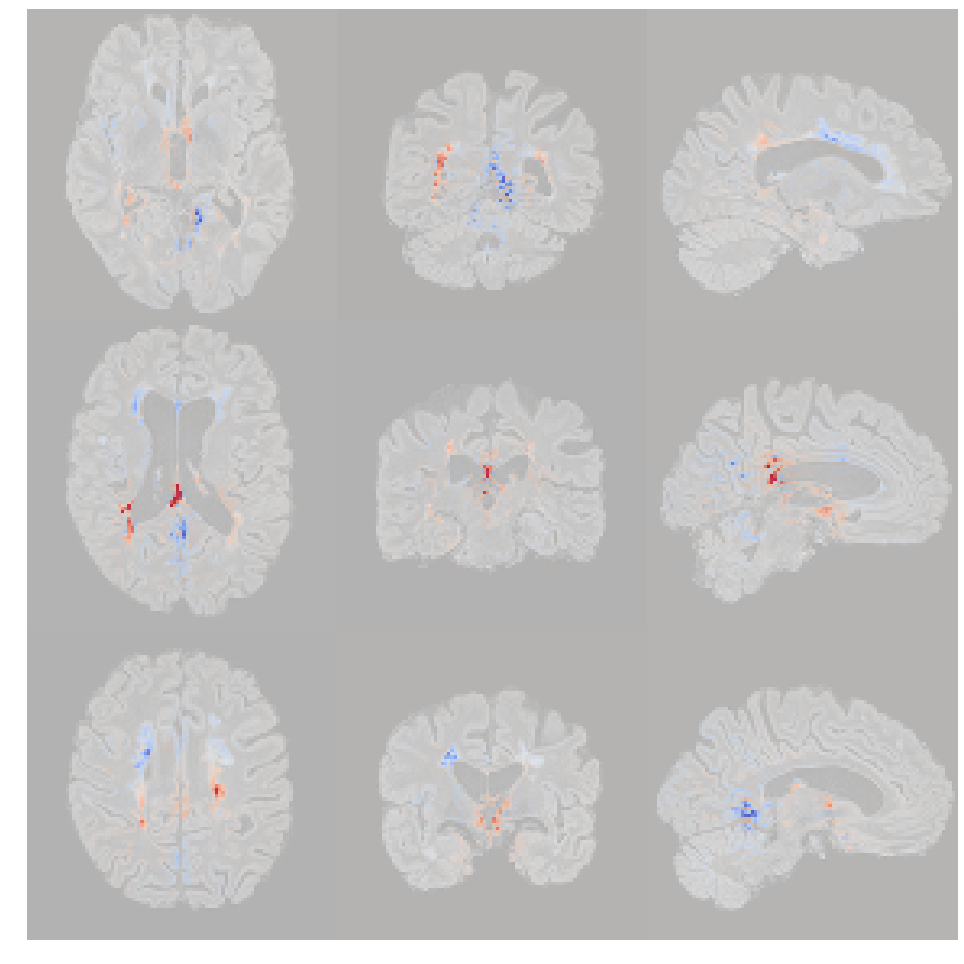

pred [1.] 
sigmoid score [0.9801063]
beheaded score 3.897254
analysis sum 5.314577


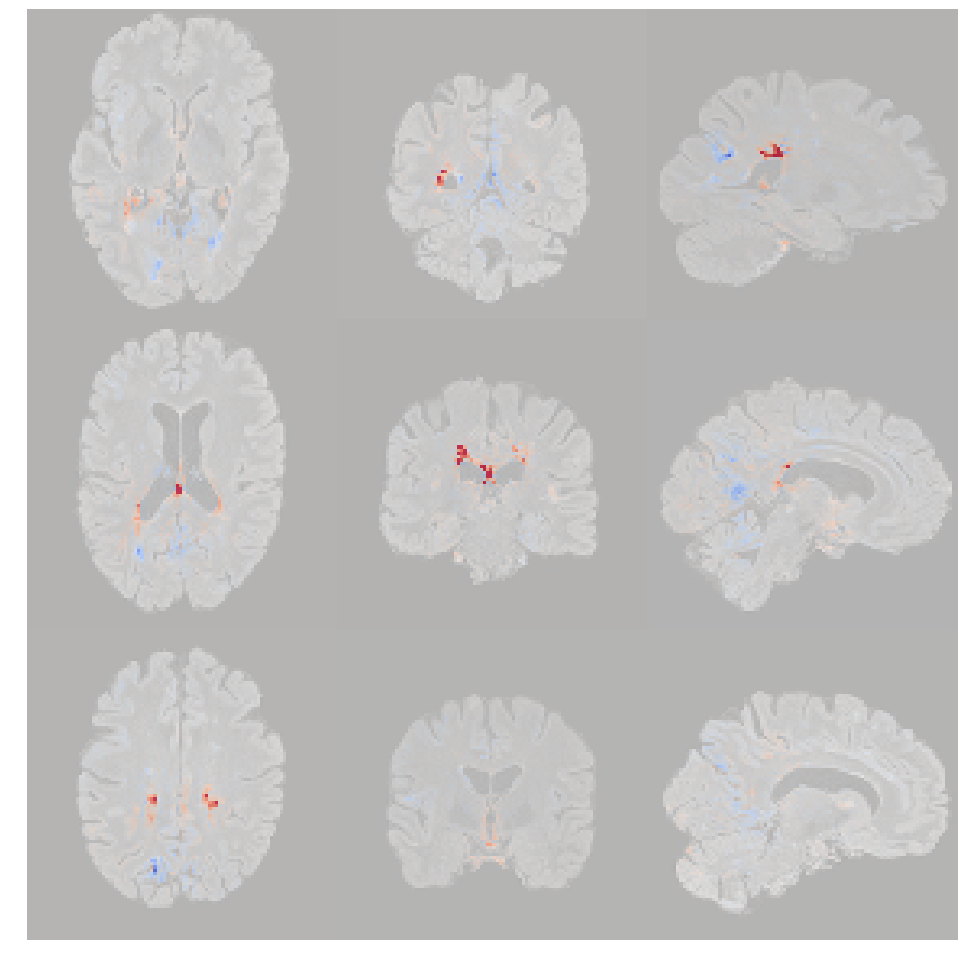

pred [1.] 
sigmoid score [0.97338426]
beheaded score 3.599277
analysis sum 4.413383


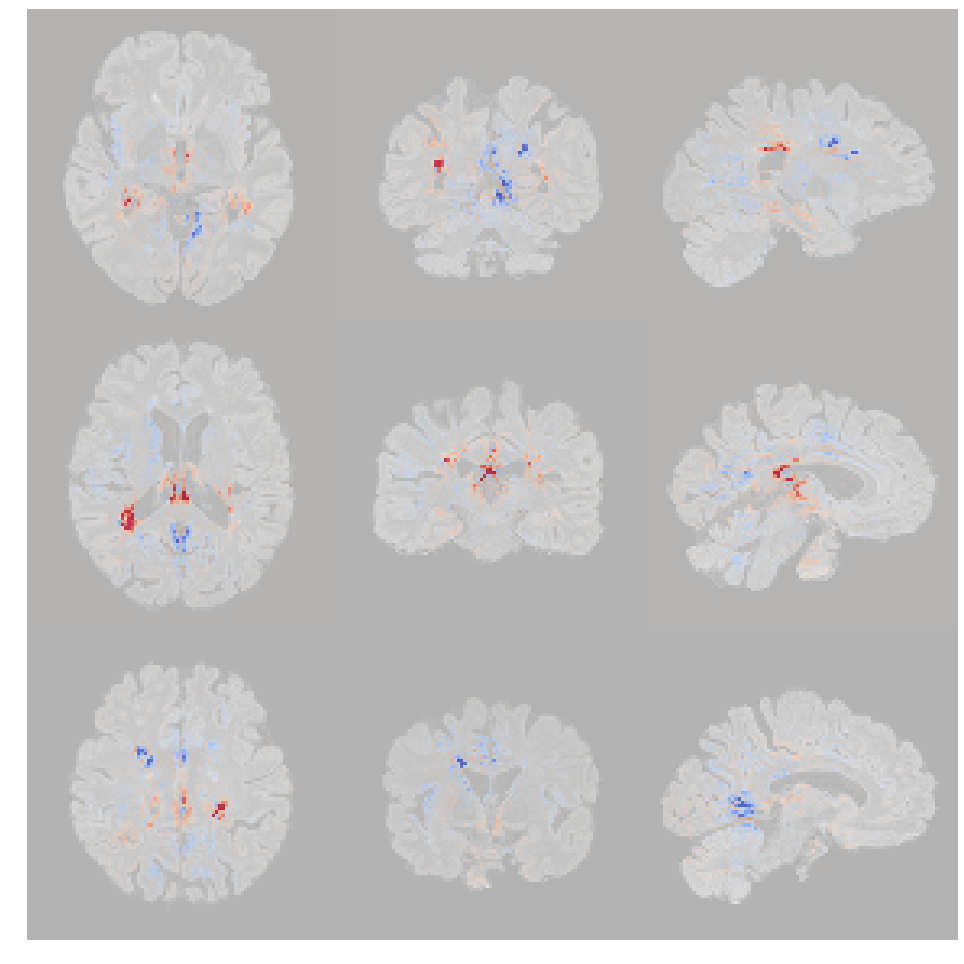

pred [1.] 
sigmoid score [0.9706222]
beheaded score 3.497698
analysis sum 5.073507


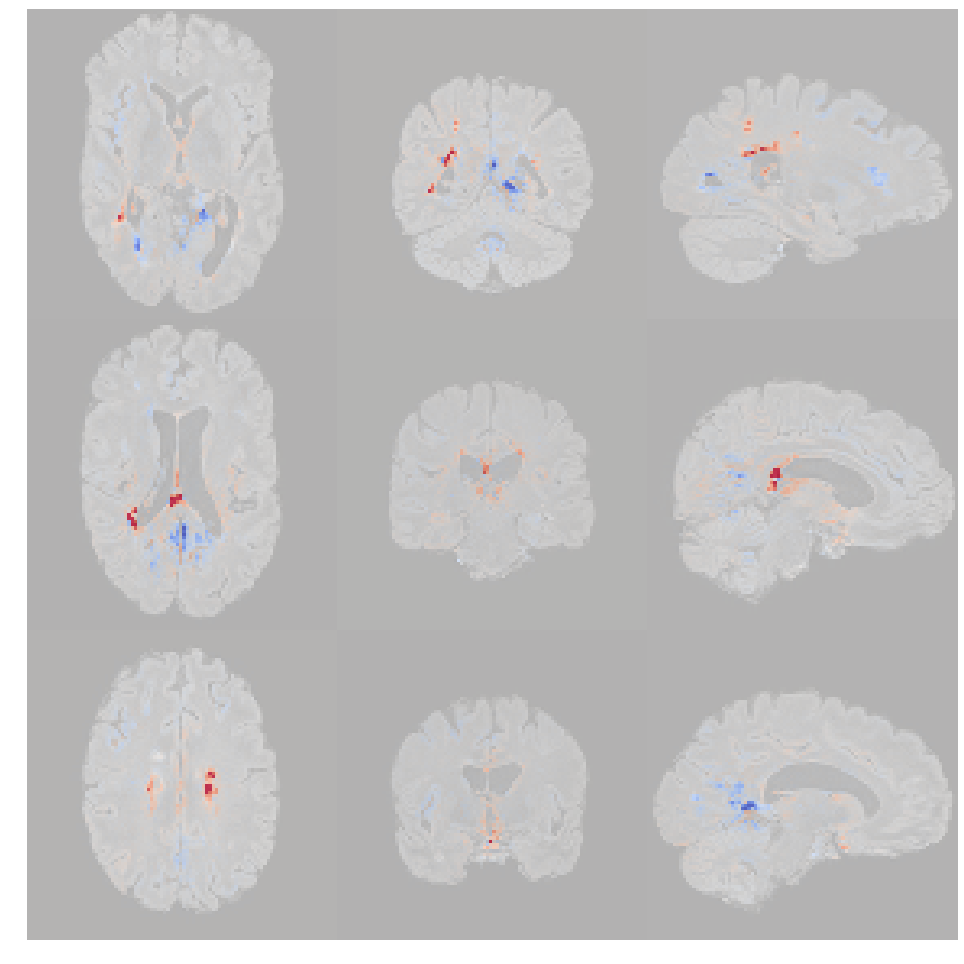

In [1448]:
# Creating an analyzer
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", beheaded_model)
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)

#image_idx = 6 # very high correct sigmoid score

# idx list defined above
for image_idx in idx_list:
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Get predictions
    be_score = beheaded_model.predict(image)
    score = model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))

    #a = list(range(15, 80, 5)) # full
    #b = list(range(16, 114, 8)) # full
    a = list(range(39, 56, 8)) # central slices
    b = list(range(40, 76, 12)) # central slices
    c = list(range(36, 56, 8)) # central slices

    #a = list(range(15, 80, 20)) # debug variant
    #b = list(range(16, 114, 24)) # debug variant
    show_cb = False
    sl = zip(a, b, c)
    #fp = None
    fp = os.path.join(image_file_dir, "MS_holdout_idx_{}_LRP_epsilon_0-001_central_slices.png".format(str(image_idx)))
    plot_heatmap2(analysis, image, vmin, vmax, title=str(label), cmap='coolwarm',
                  sl=sl, show_average=False, show_colorbar=show_cb, file_path=fp)

### Healthy controls

In [1509]:
# get the lowest scores i.e. best classification for HC
idx_list = np.argsort(np.array(scores))[:4]

print("#########")
for idx in idx_list:
    print("Index %i" %idx)
    print("Score %f" % scores[idx])
    print("#########")

#########
Index 19
Score 0.098773
#########
Index 3
Score 0.229042
#########
Index 20
Score 0.273408
#########
Index 17
Score 0.276104
#########


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


pred [0.] 
sigmoid score [0.09877317]
beheaded score -2.210931
analysis sum -2.669525


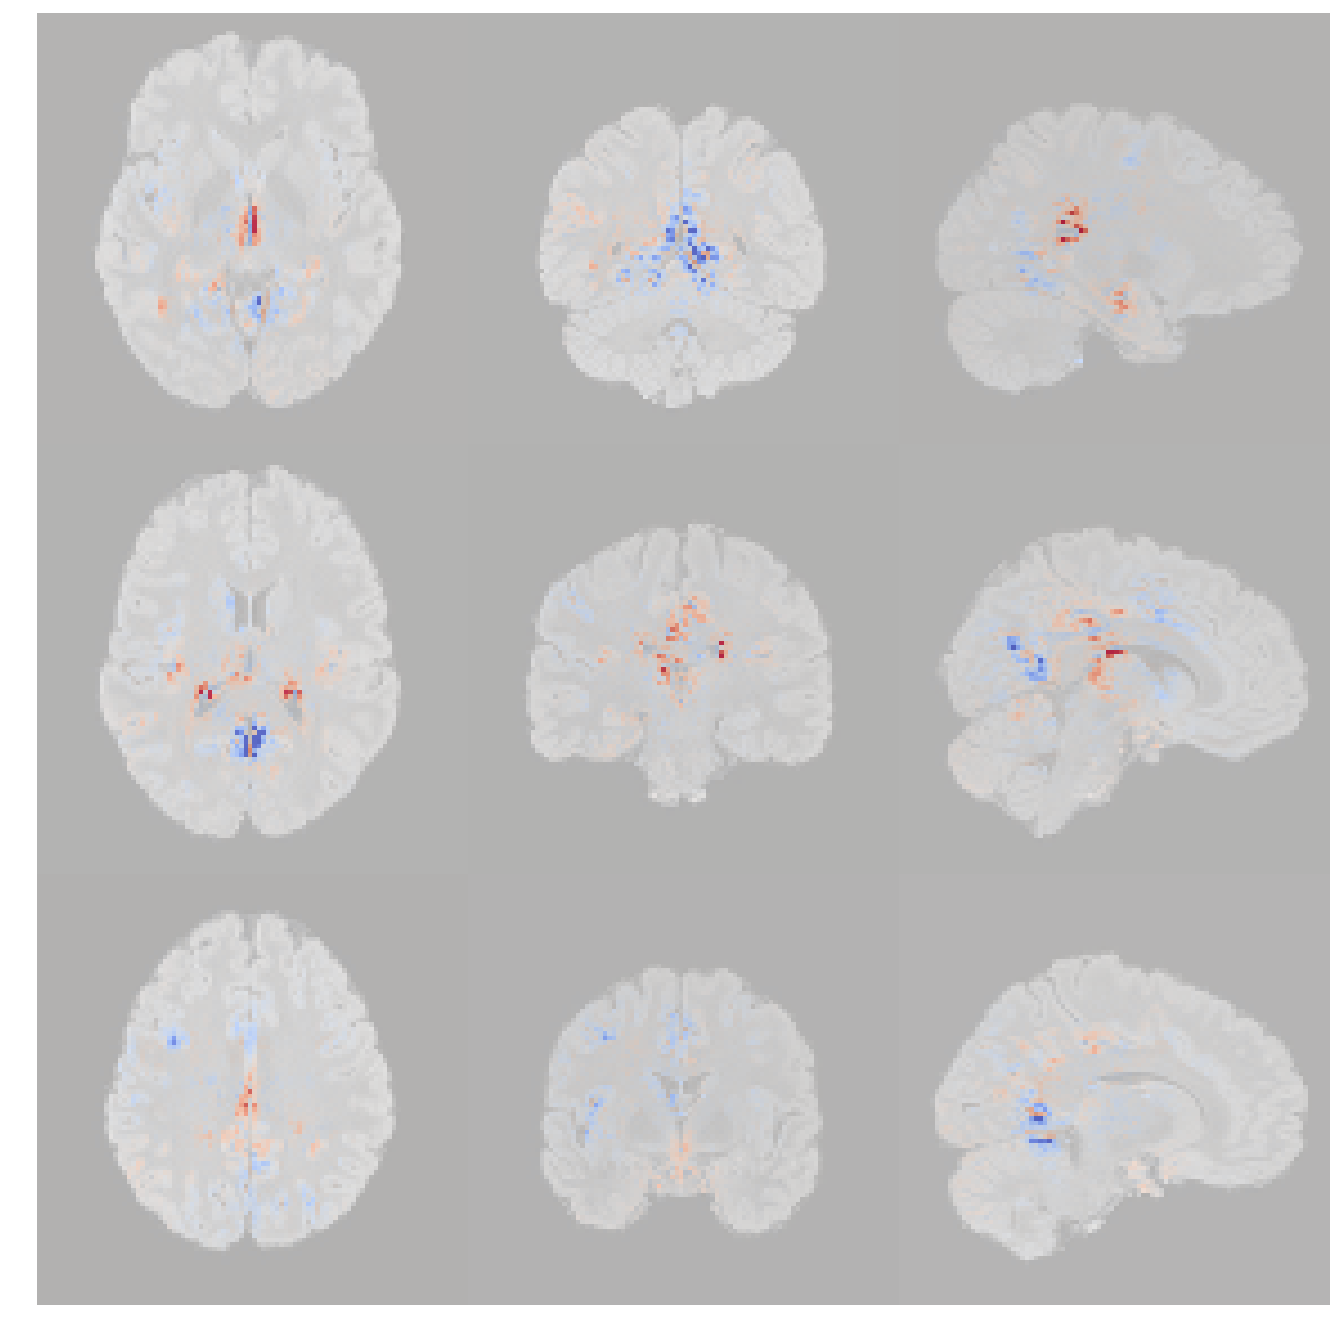

pred [0.] 
sigmoid score [0.2290421]
beheaded score -1.213728
analysis sum -1.658455


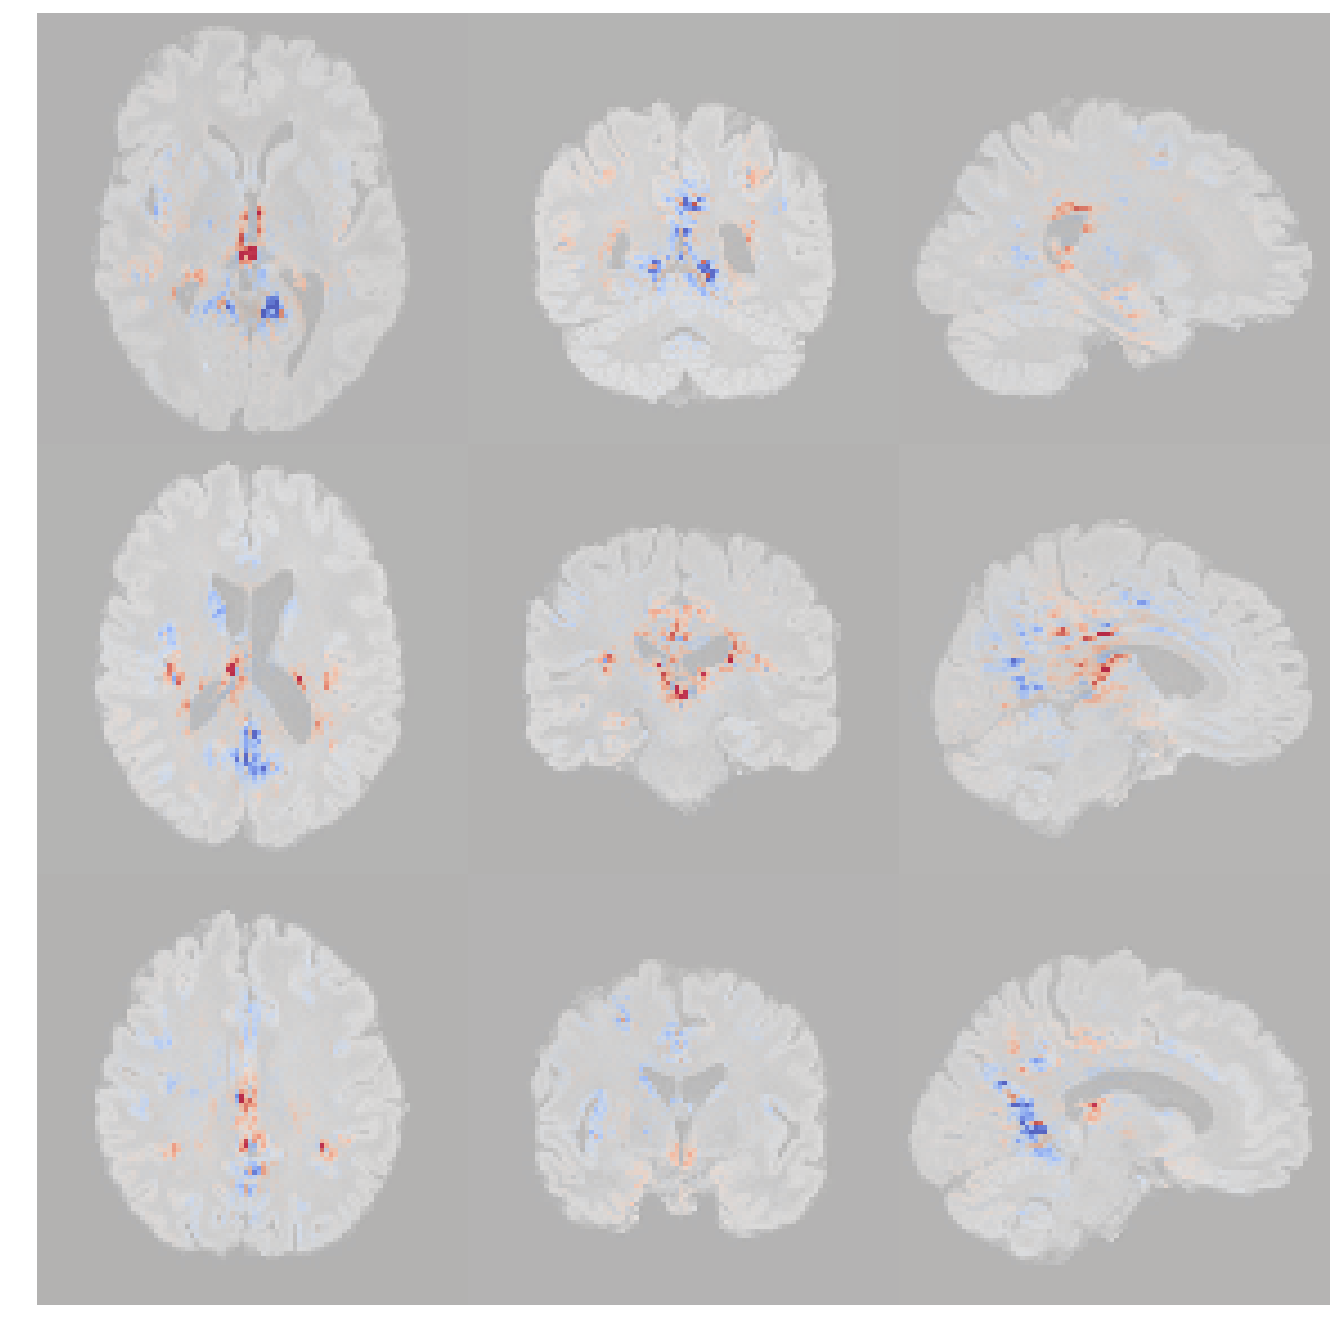

pred [0.] 
sigmoid score [0.27340817]
beheaded score -0.977399
analysis sum -1.177916


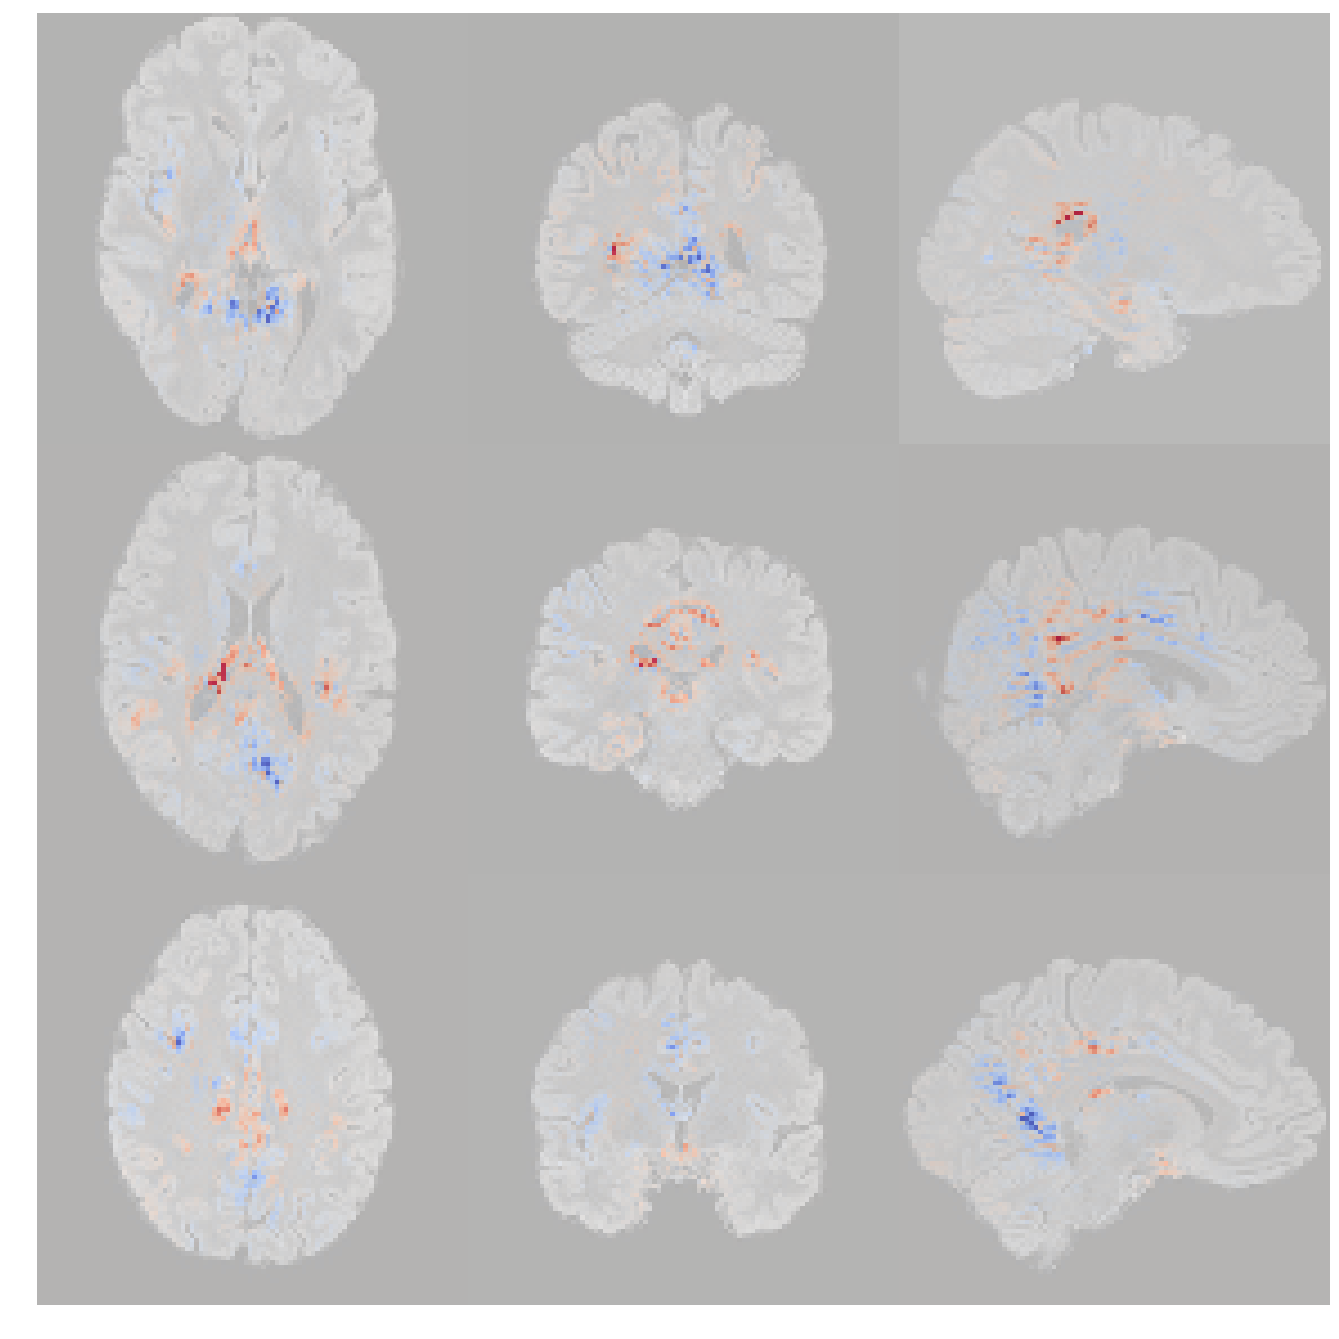

pred [0.] 
sigmoid score [0.27610388]
beheaded score -0.963871
analysis sum -1.569889


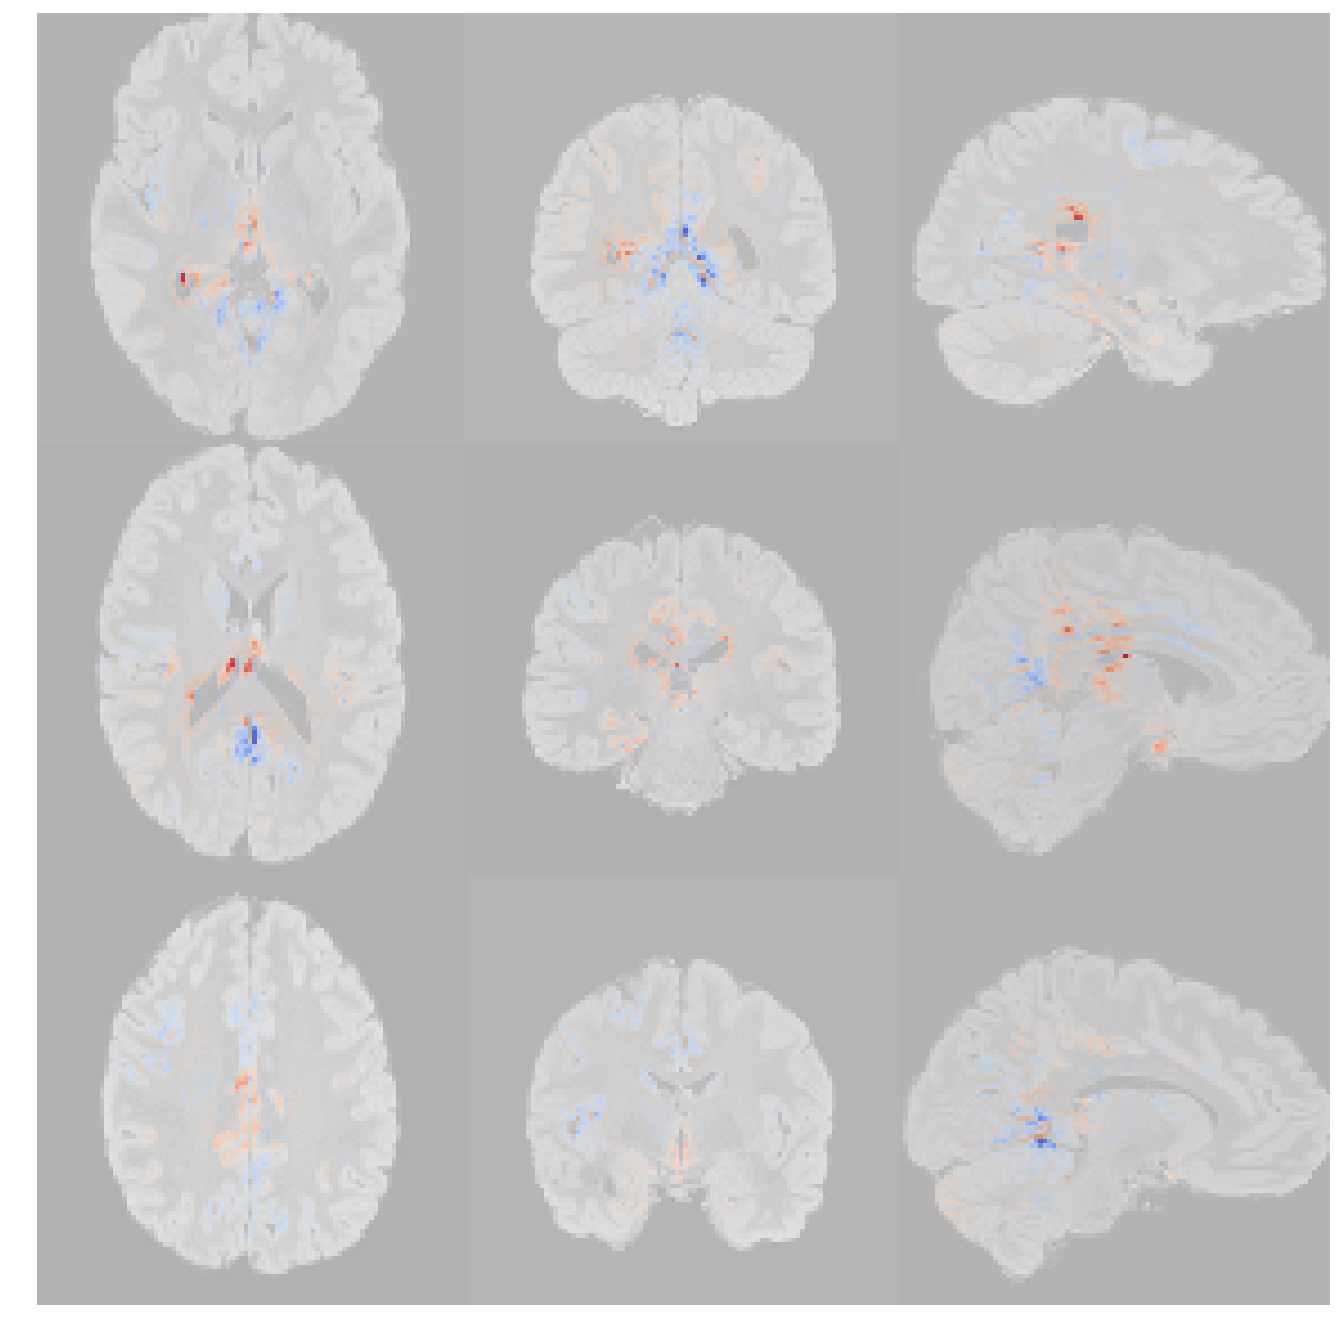

In [1520]:
# Creating an analyzer
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", beheaded_model)
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)

#image_idx = 6 # very high correct sigmoid score

# idx list defined above
for image_idx in idx_list:
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Get predictions
    be_score = beheaded_model.predict(image)
    score = model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))

    #a = list(range(15, 80, 5)) # full
    #b = list(range(16, 114, 8)) # full
    a = list(range(39, 56, 8)) # central slices
    b = list(range(40, 76, 12)) # central slices
    c = list(range(36, 56, 8)) # central slices

    #a = list(range(15, 80, 20)) # debug variant
    #b = list(range(16, 114, 24)) # debug variant
    show_cb = False
    sl = zip(a, b, c)
    #fp = None
    fp = os.path.join(image_file_dir, "HC_holdout_idx_{}_LRP_epsilon_0-001_central_slices.png".format(str(image_idx)))
    plot_heatmap2(analysis, image, vmin, vmax, title=str(label), cmap='coolwarm',
                  sl=sl, show_average=False, show_colorbar=show_cb, file_path=fp)

# Visualizing all holdout scans

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


pred [1.] 
sigmoid score [0.5888045]
beheaded score 0.359025
analysis sum 0.920706


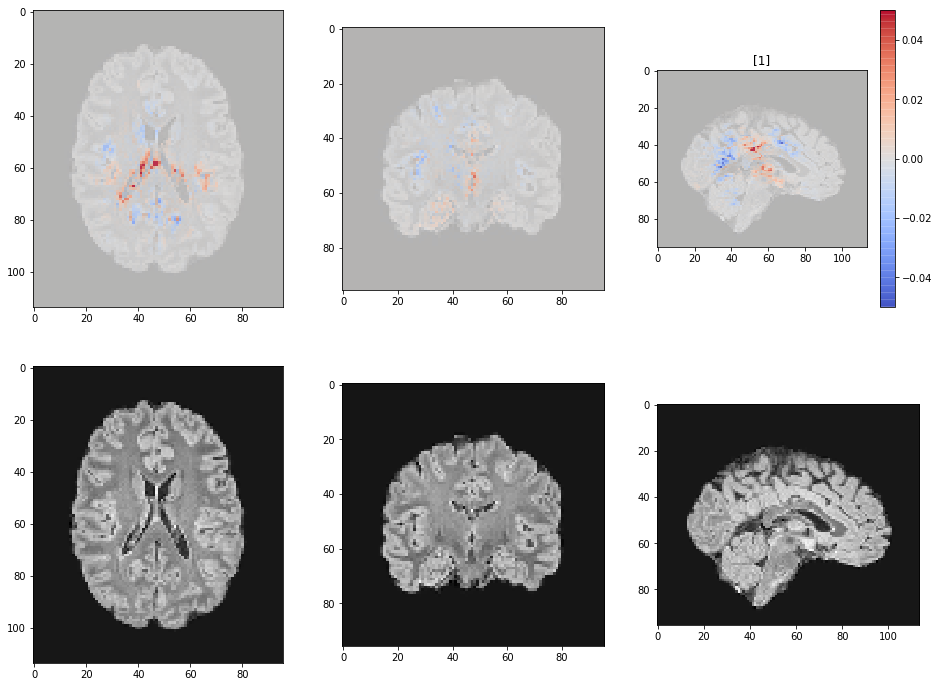

pred [1.] 
sigmoid score [0.63422424]
beheaded score 0.550382
analysis sum 0.639513


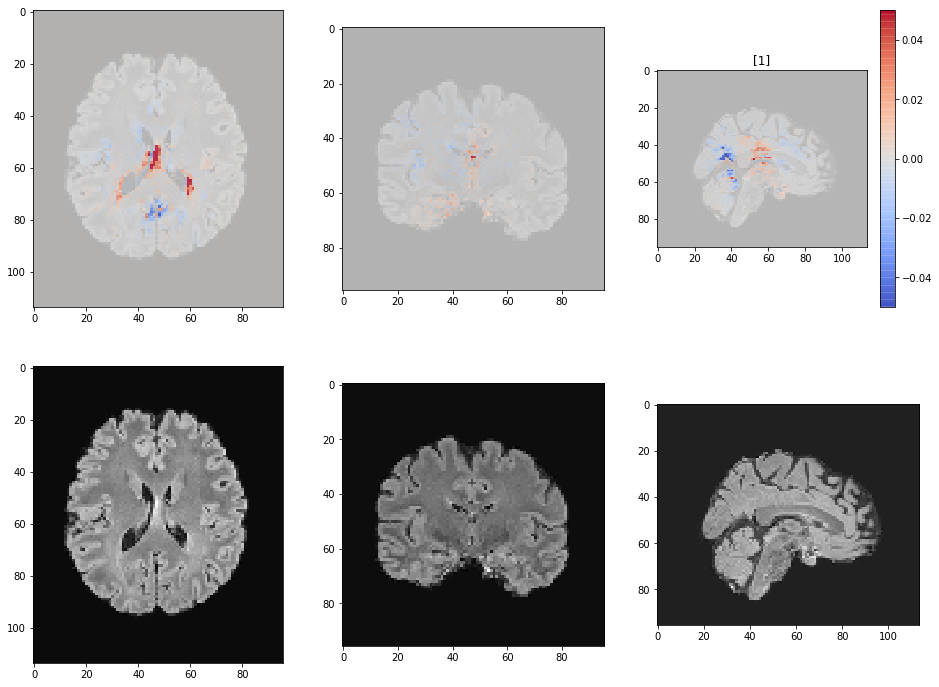

pred [0.] 
sigmoid score [0.3602204]
beheaded score -0.574408
analysis sum -0.527786


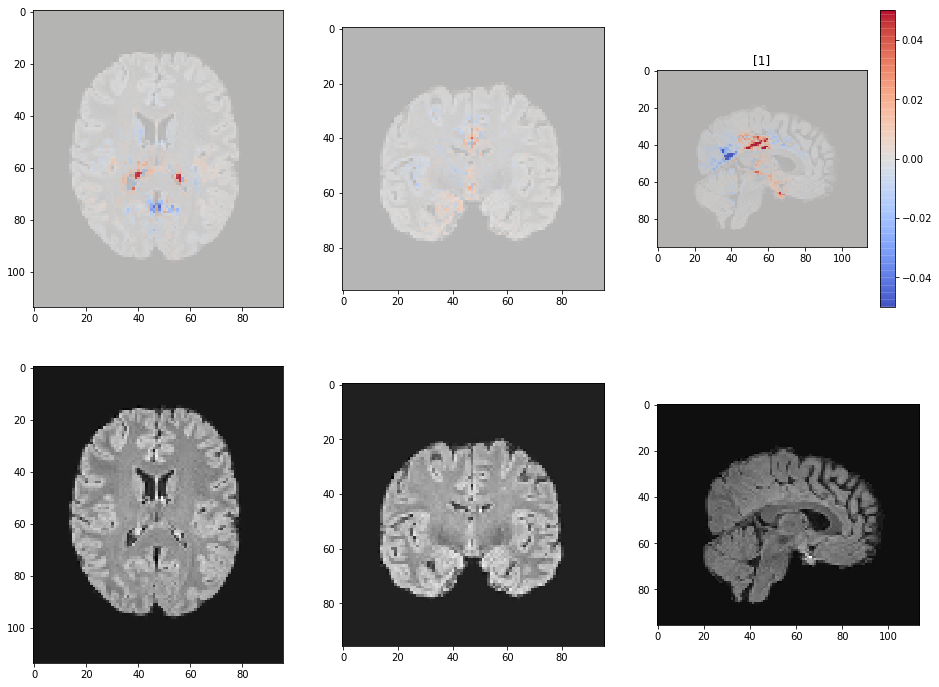

pred [0.] 
sigmoid score [0.2290421]
beheaded score -1.213728
analysis sum -1.658455


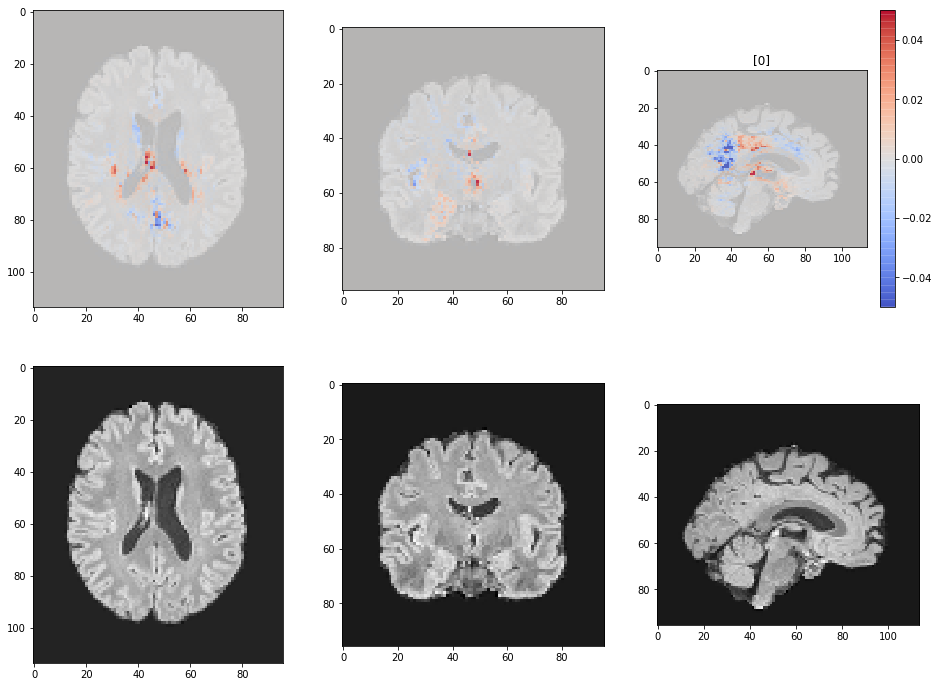

pred [1.] 
sigmoid score [0.9801063]
beheaded score 3.897254
analysis sum 5.314578


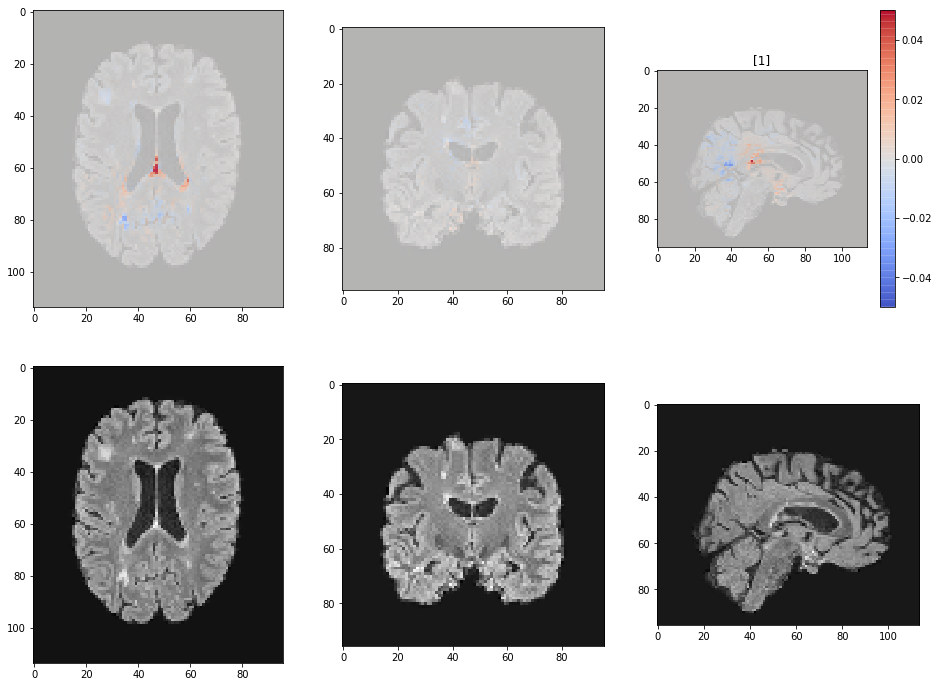

pred [0.] 
sigmoid score [0.28947553]
beheaded score -0.897933
analysis sum -0.841029


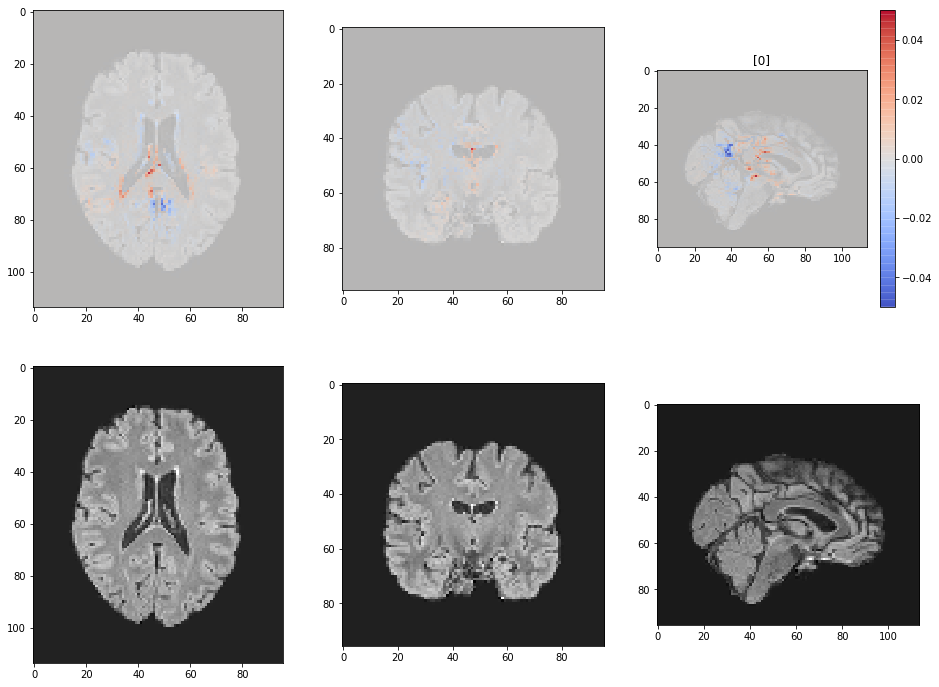

pred [1.] 
sigmoid score [0.99642295]
beheaded score 5.629638
analysis sum 6.679100


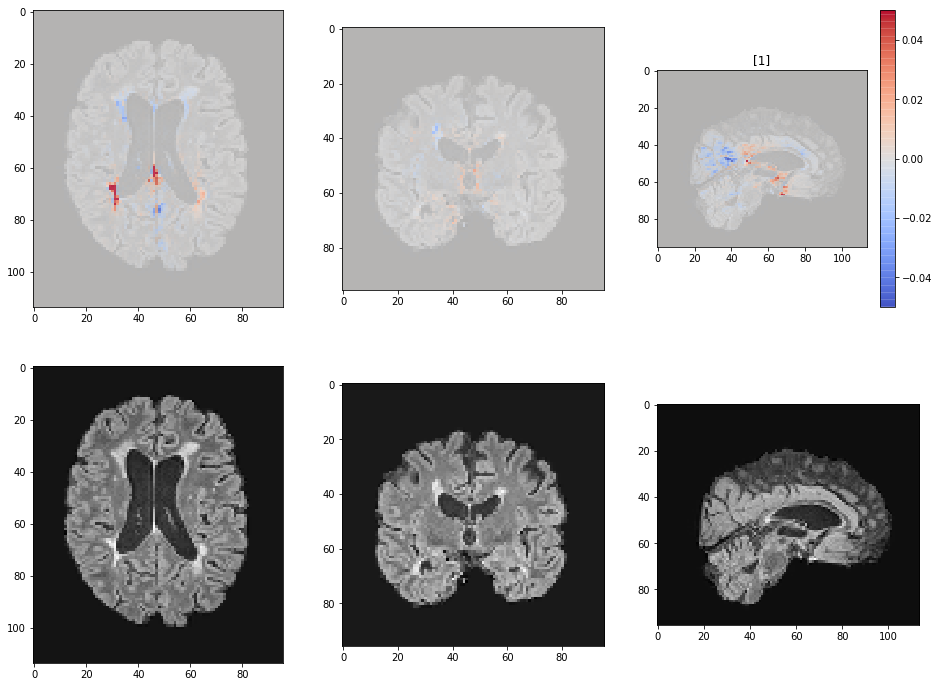

pred [0.] 
sigmoid score [0.34410045]
beheaded score -0.645074
analysis sum -0.814157


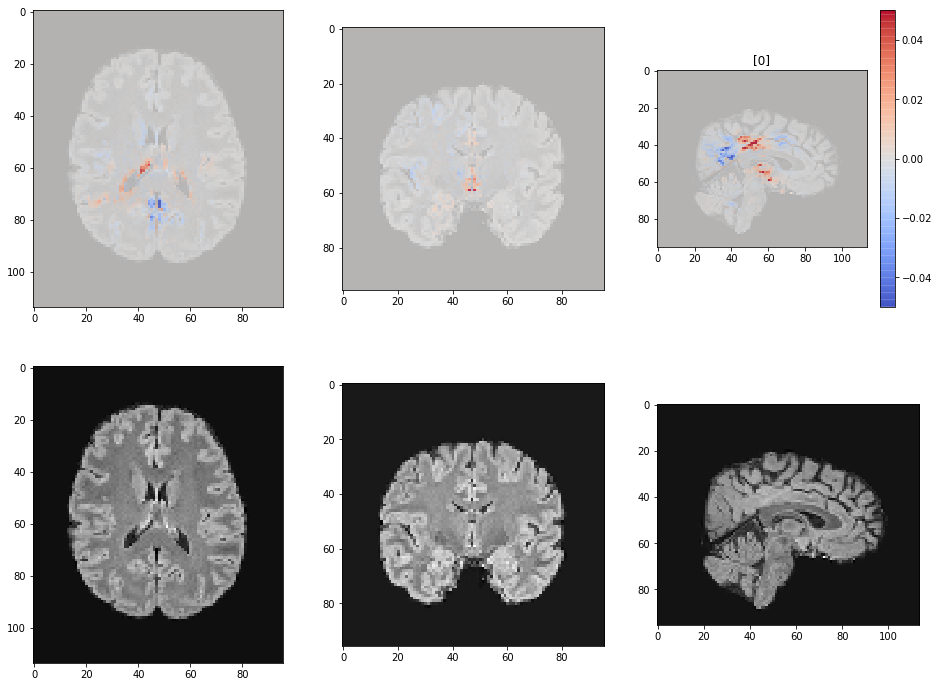

pred [1.] 
sigmoid score [0.97338426]
beheaded score 3.599277
analysis sum 4.413381


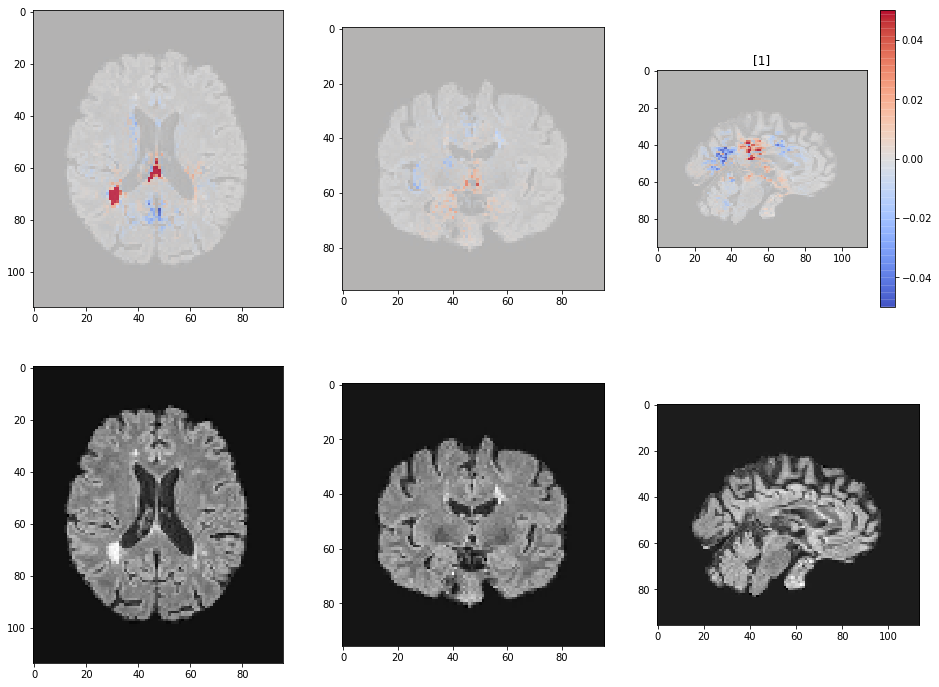

pred [1.] 
sigmoid score [0.8503438]
beheaded score 1.737301
analysis sum 2.124649


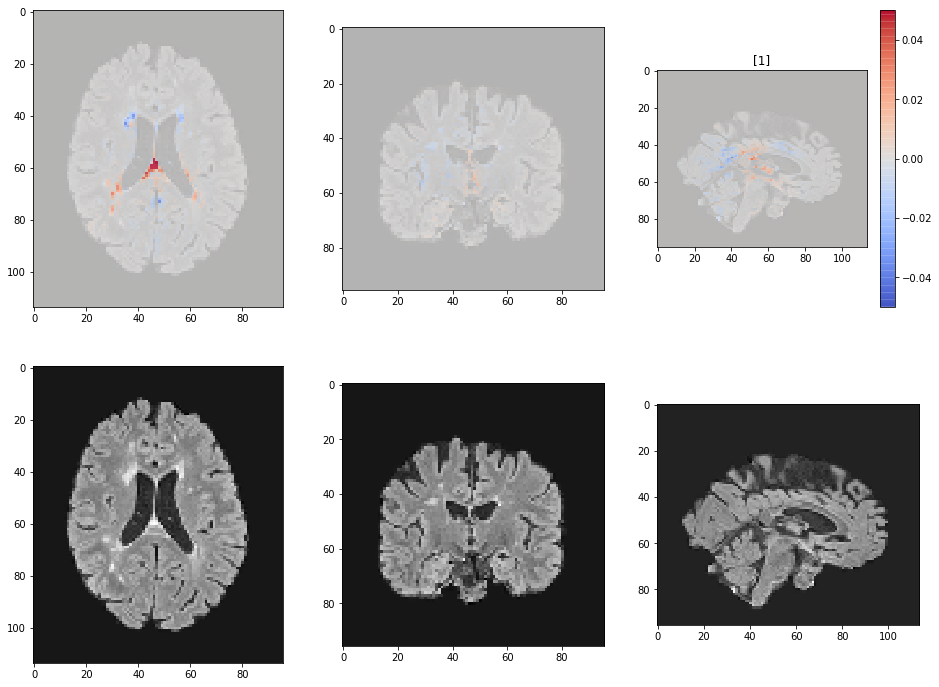

pred [0.] 
sigmoid score [0.39456418]
beheaded score -0.428167
analysis sum -0.713912


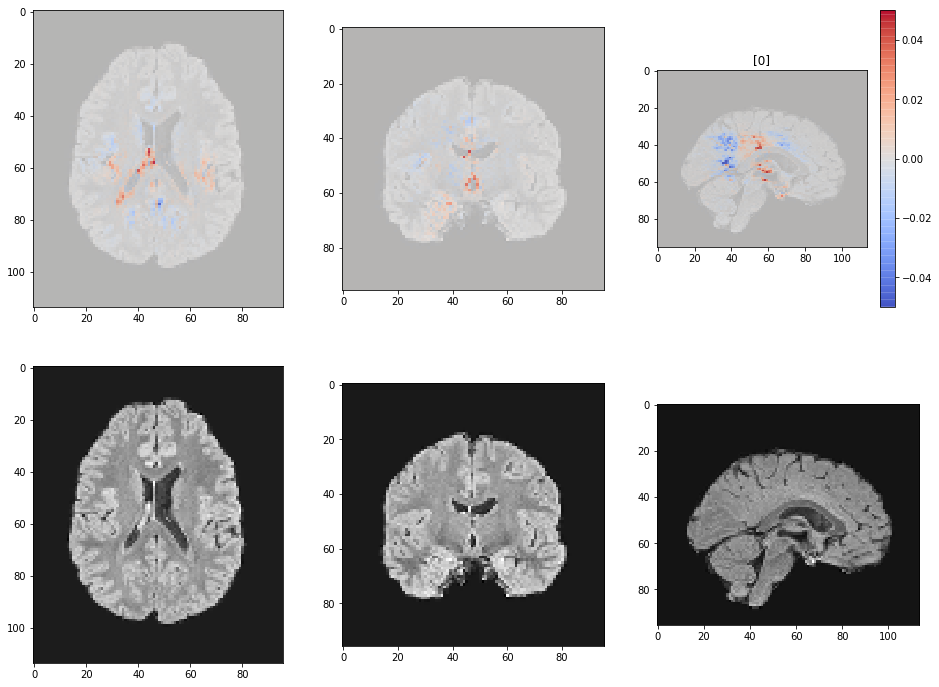

pred [1.] 
sigmoid score [0.8818087]
beheaded score 2.009670
analysis sum 2.830434


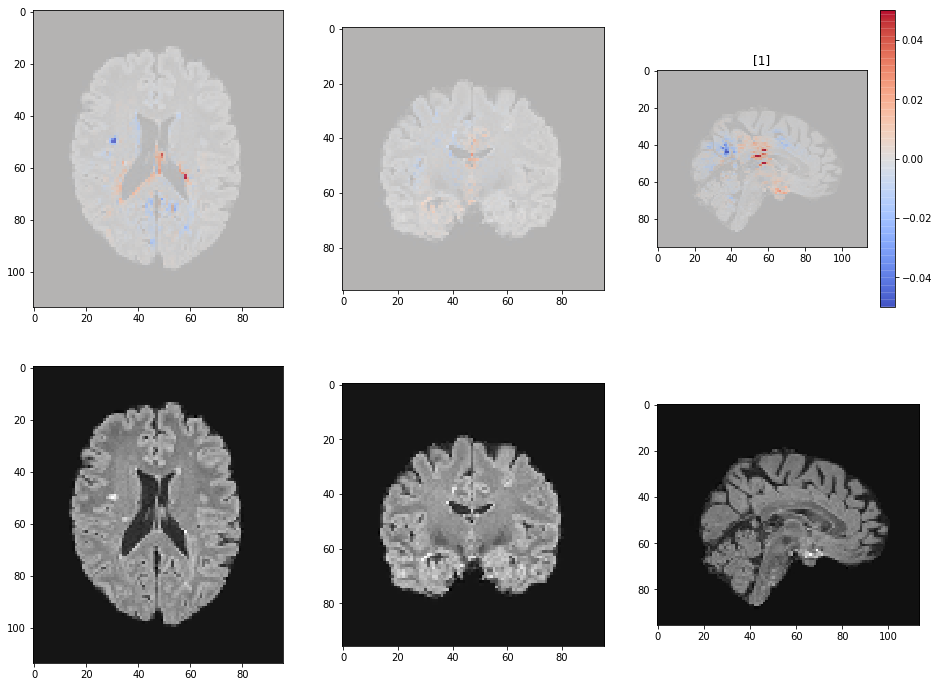

pred [1.] 
sigmoid score [0.9706222]
beheaded score 3.497698
analysis sum 5.073507


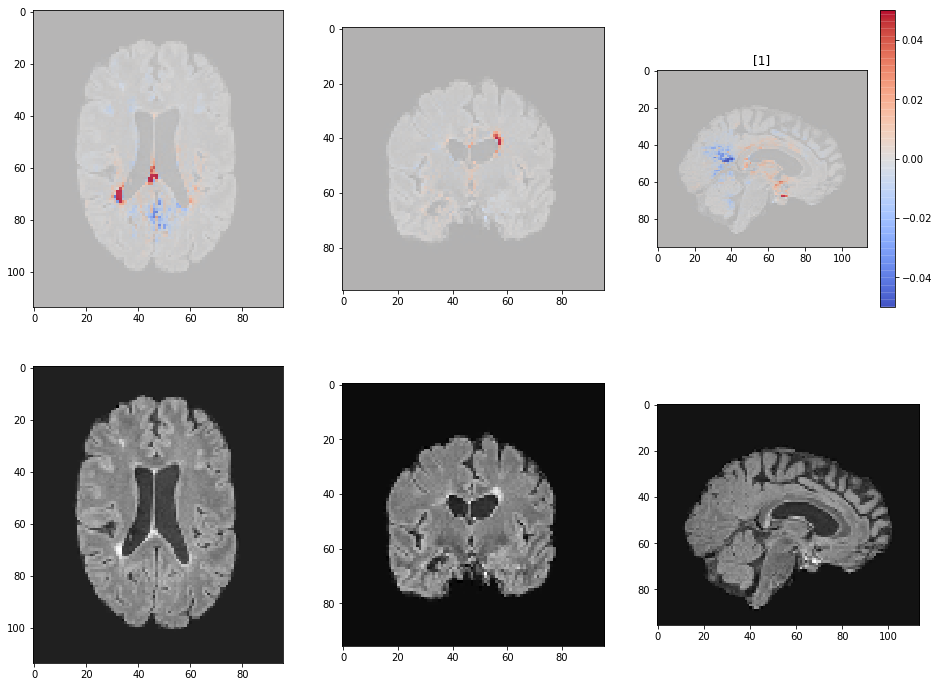

pred [1.] 
sigmoid score [0.728988]
beheaded score 0.989494
analysis sum 1.226548


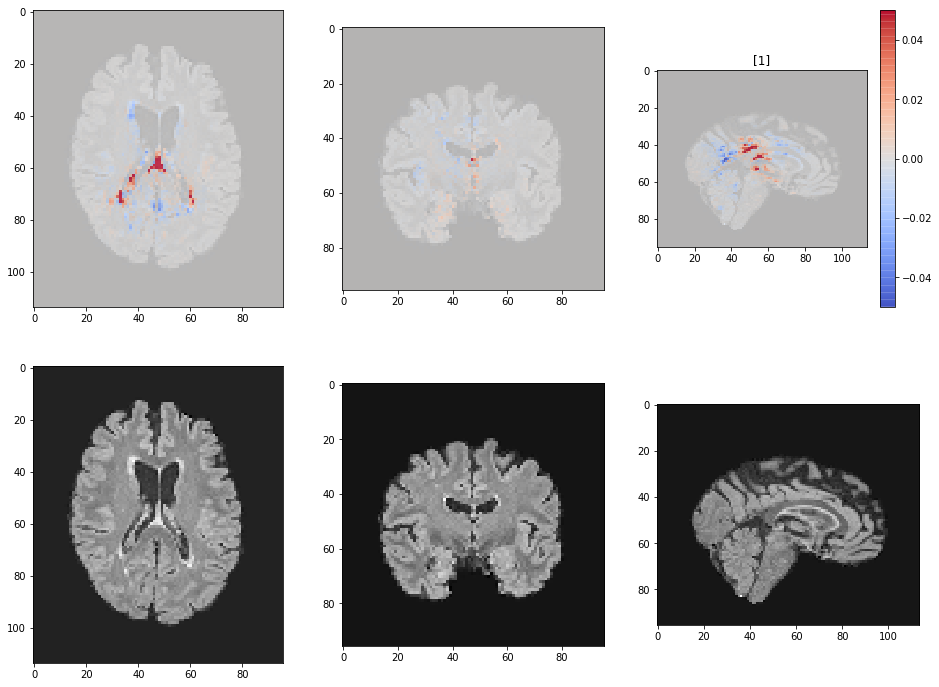

pred [1.] 
sigmoid score [0.9030025]
beheaded score 2.231040
analysis sum 3.009446


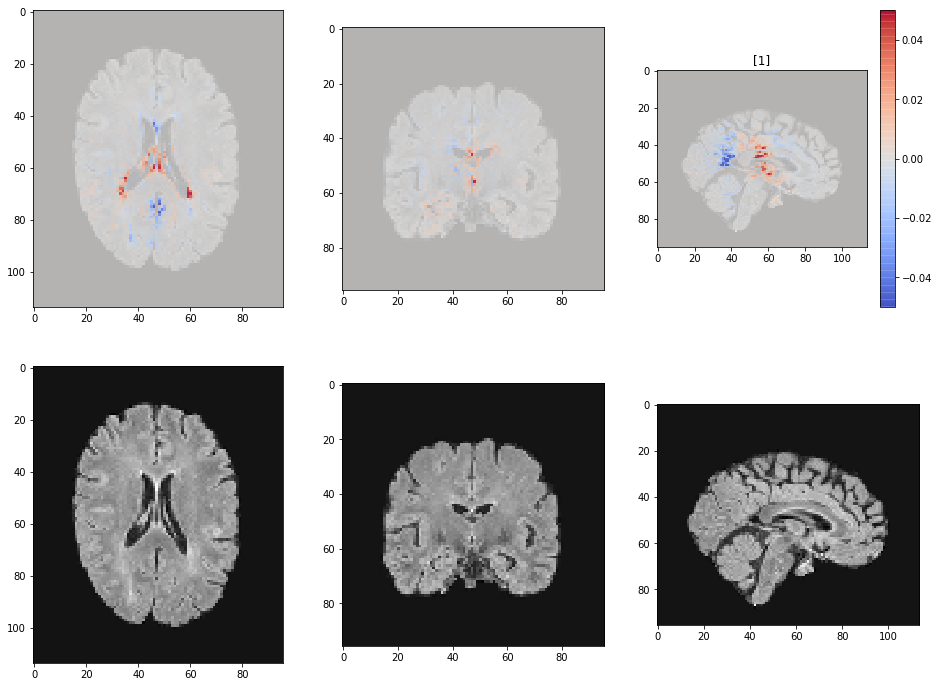

pred [0.] 
sigmoid score [0.36676332]
beheaded score -0.546127
analysis sum -0.611052


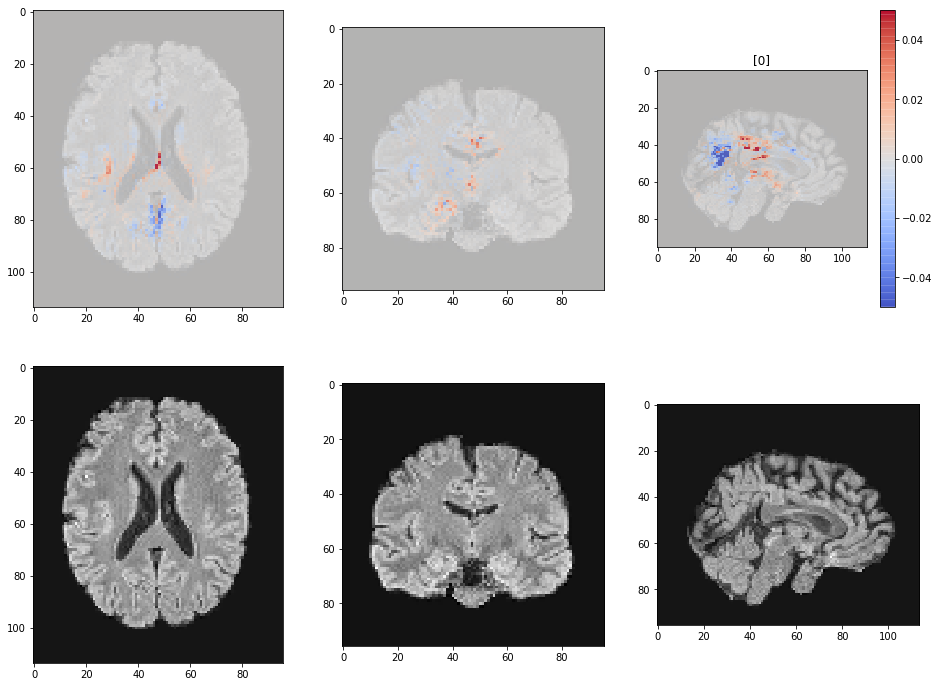

pred [1.] 
sigmoid score [0.6544661]
beheaded score 0.638729
analysis sum 1.263523


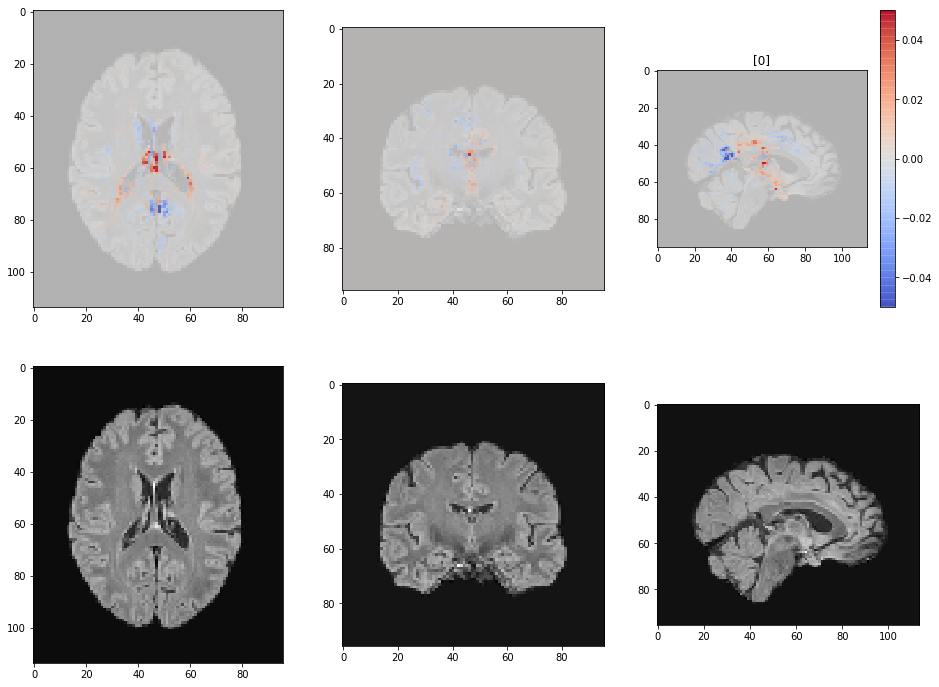

pred [0.] 
sigmoid score [0.27610388]
beheaded score -0.963871
analysis sum -1.569889


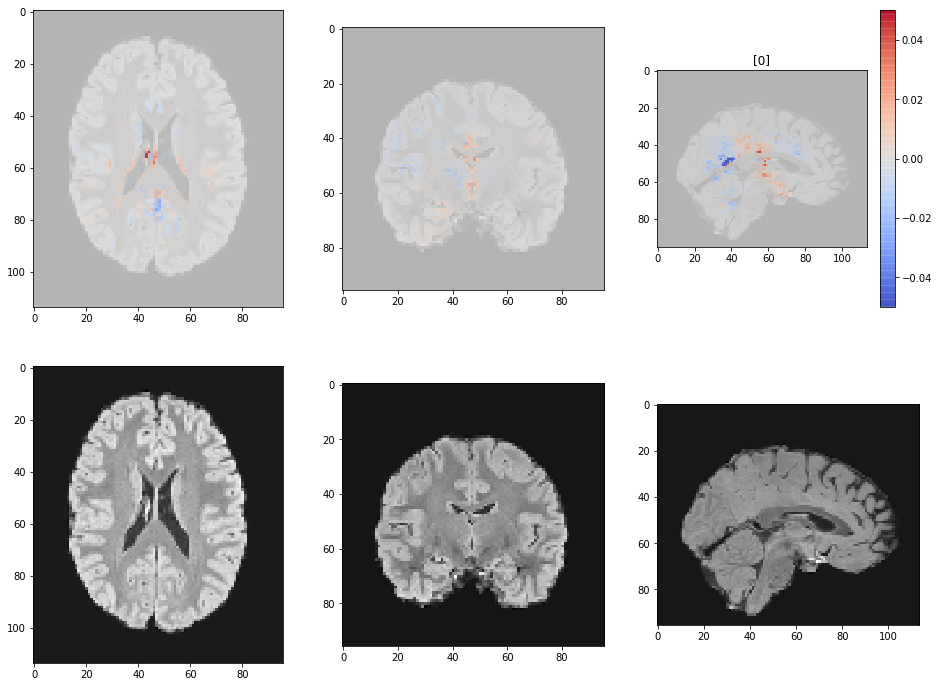

pred [1.] 
sigmoid score [0.9633791]
beheaded score 3.269826
analysis sum 4.172567


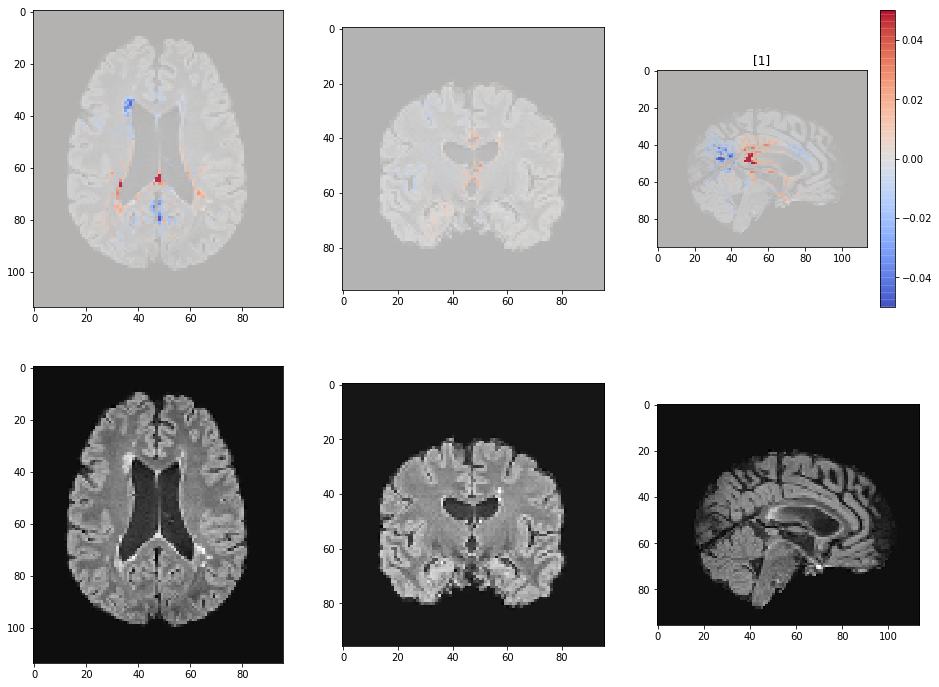

pred [0.] 
sigmoid score [0.09877317]
beheaded score -2.210931
analysis sum -2.669526


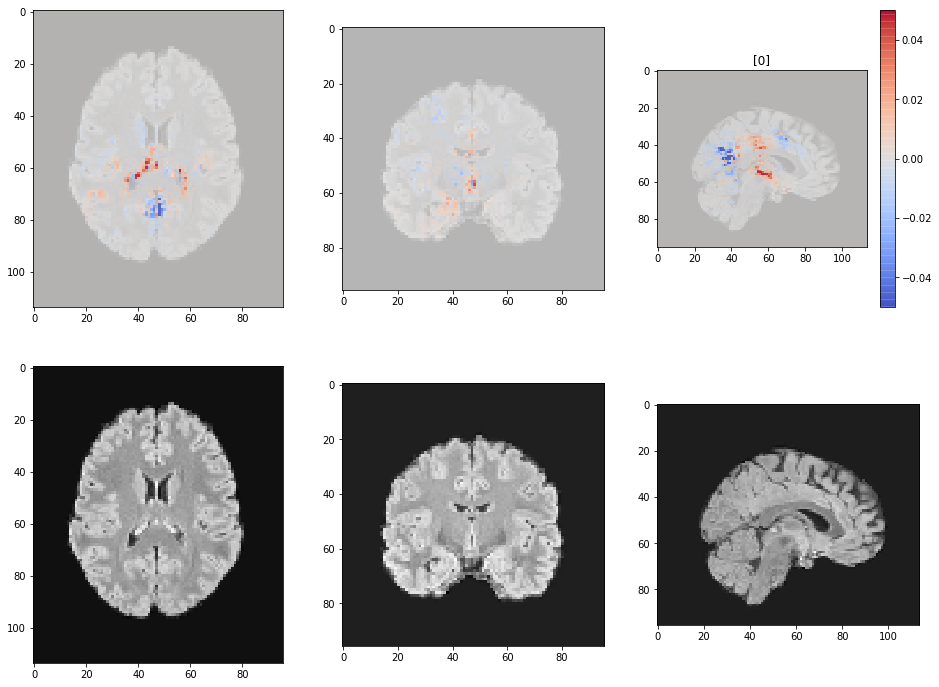

pred [0.] 
sigmoid score [0.27340817]
beheaded score -0.977399
analysis sum -1.177915


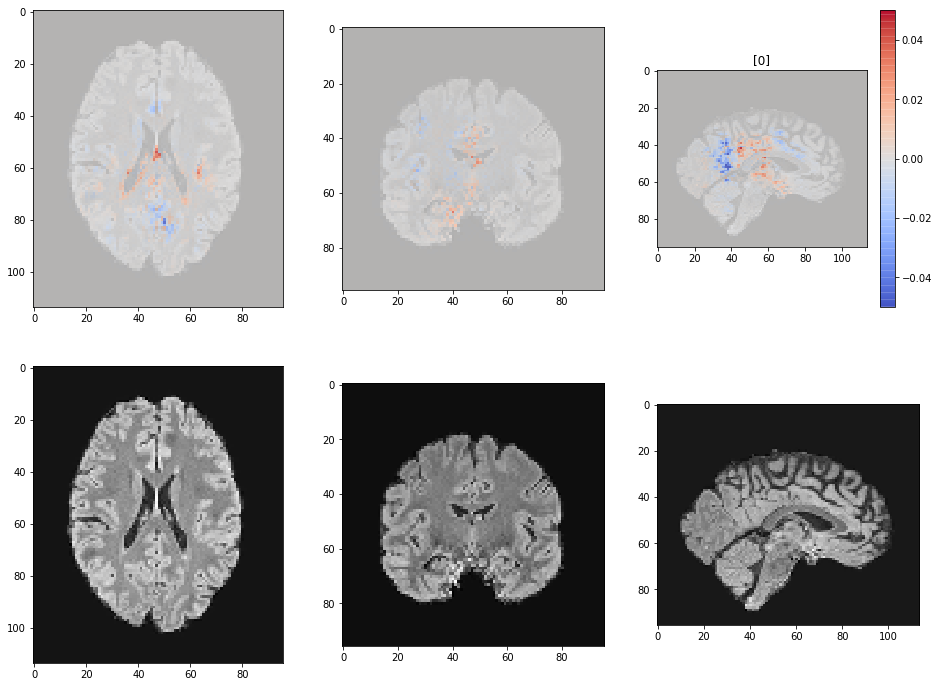

pred [1.] 
sigmoid score [0.86228323]
beheaded score 1.834385
analysis sum 2.327689


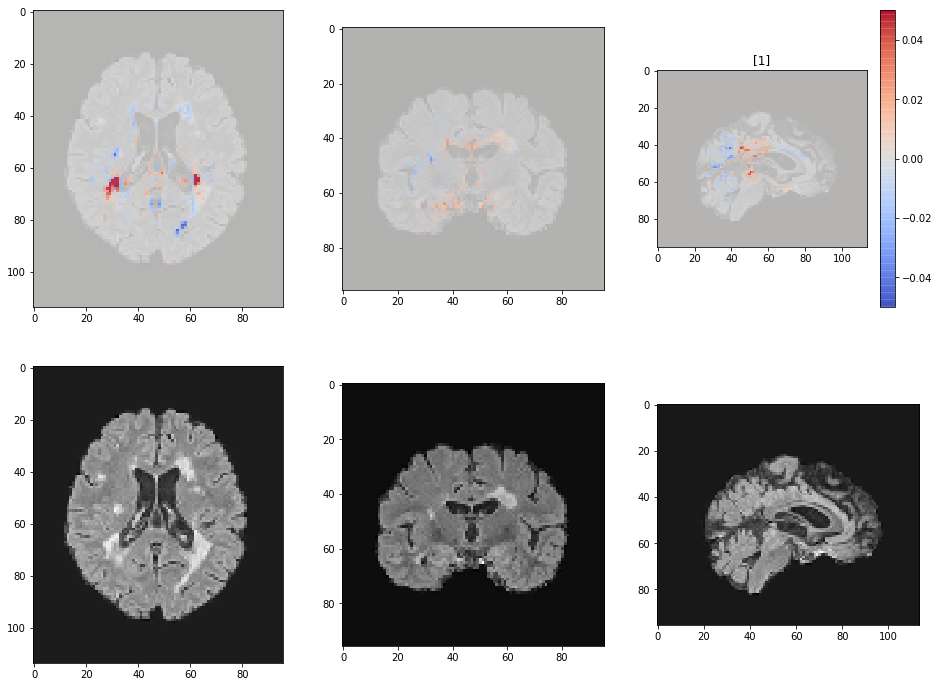

pred [0.] 
sigmoid score [0.45107046]
beheaded score -0.196346
analysis sum 0.141054


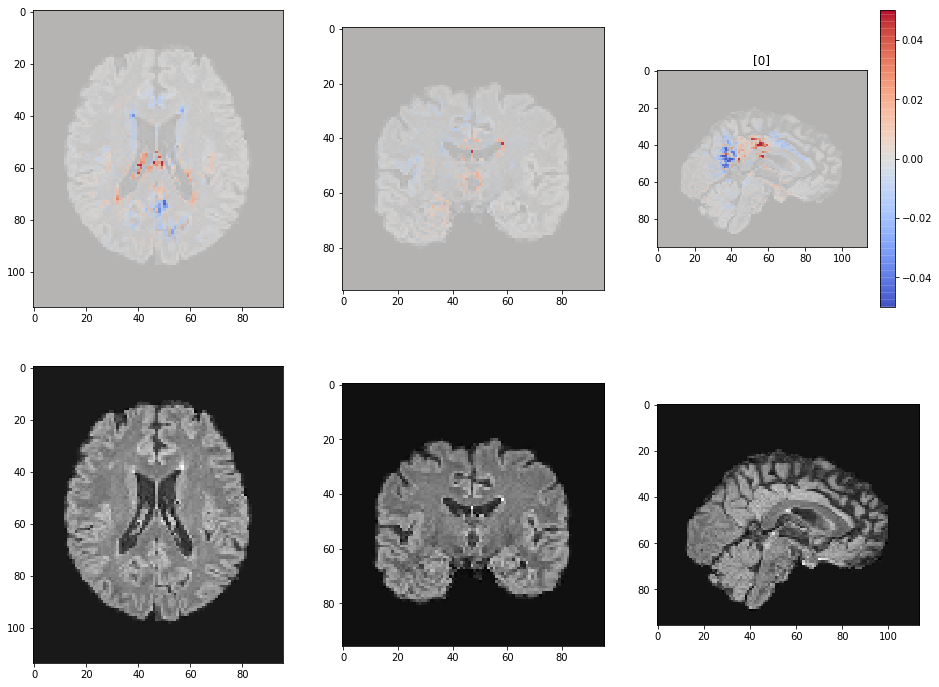

In [900]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", beheaded_model)

for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]
    # Get predictions
    be_score = beheaded_model.predict(image)
    score = model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))
    plot_heatmap(analysis, image, vmin, vmax, title=str(label), cmap='coolwarm')

In [ ]:
#quit()